# Decoding the US Cab Industry: Data-Driven Investment Intelligence

### Business Problem

XYZ, a private firm in the US, has observed significant growth in the Cab Industry in recent years and the presence of several key players in the market. The company is considering making an investment in the Cab industry and, in alignment with their Go-to-Market (G2M) strategies, they aim to thoroughly understand the market before making a final decision. XYZ seeks assistance in making this decision by conducting data analysis and selecting the right company to invest in.

### Dataset Story

There are four different data sets available covering two taxi companies from January 31, 2016, to December 31, 2018. Each data set reflects different aspects of customer profiles.

#### Cab_Data.csv
- This dataset contains transaction details for two cab companies.
- Fields include Transaction ID, Date of Travel, Company, City, KM Travelled, Price Charged, and Cost of Trip.
#### Customer_ID.csv
- A mapping table linking unique customer identifiers to their demographic details.
- Fields include Customer ID, Gender, Age, and Income (USD/Month).
#### Transaction_ID.csv
- A mapping table linking transactions to customers and their payment modes.
- Fields include Transaction ID, Customer ID, and Payment Mode.
#### City.csv
- Provides a list of US cities, their populations, and the number of cab users.

## 1. Importing Required Libraries and Datasets

### 1.1. Importing libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import statsmodels.stats.api as sms
from scipy import stats
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from IPython.display import display, HTML
from IPython.display import Image
import folium
from io import BytesIO
import base64
import ast
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_period_transactions,plot_probability_alive_matrix, plot_frequency_recency_matrix
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

import warnings
warnings.simplefilter("ignore")

### 1.2. Reading datasets:

In [2]:
df_cab = pd.read_csv('/Users/handeatasagun/Documents/GitHub/DataSets/Cab_Data.csv')
df_customer = pd.read_csv('/Users/handeatasagun/Documents/GitHub/DataSets/Customer_ID.csv')
df_transaction = pd.read_csv('/Users/handeatasagun/Documents/GitHub/DataSets/Transaction_ID.csv')
df_city = pd.read_csv('/Users/handeatasagun/Documents/GitHub/DataSets/City.csv')
df_coordinates = pd.read_csv('city_coordinates.csv') # Shows the map coordinates of some cities in the US.

## 2. Exploratory Data Analysis (EDA)

### 2.1. Data frame inspection function:

This function is designed to inspect and provide a summary of the essential characteristics and information of a dataframe.

In [3]:
def check_df(dataframe, head=5):
    display(HTML(f"<h3>Types</h3>{dataframe.dtypes.to_frame().to_html()}"))
    display(HTML(f"<h3>Head</h3>{dataframe.head(head).to_html()}"))
    display(HTML(f"<h3>Shape</h3>{dataframe.shape}"))
    display(HTML(f"<h3>NA</h3>{dataframe.isnull().sum().to_frame().to_html()}"))
    display(HTML(f"<h3>Quantiles</h3>{dataframe.describe([0.25, 0.50, 0.95]).T.to_html()}"))

#### 2.1.1. For "df_cab":

- The date data (Date of Travel) needs to be converted to datetime format.
- The data type of the 'Transaction ID' column should be changed to string.
- The dataframe contains information on 359,392 travel transactions.
- No missing values are present in the dataset.
- The average distance traveled is 22.567 kilometers, and the average price charged is $423.443.
- The mean of the cost of trip is around 286 dollars.

In [4]:
check_df(df_cab)

,0
Transaction ID,int64
Date of Travel,int64
Company,object
City,object
KM Travelled,float64
Price Charged,float64
Cost of Trip,float64


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.450,370.950,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.620,358.520,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.040,125.200,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.170,377.400,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.730,114.620,97.776


,0
Transaction ID,0
Date of Travel,0
Company,0
City,0
KM Travelled,0
Price Charged,0
Cost of Trip,0


,count,mean,std,min,25%,50%,95%,max
Transaction ID,359392.000,10220761.185,126805.804,10000011.000,10110809.750,10221035.500,10418091.450,10440107.000
Date of Travel,359392.000,42964.068,307.467,42371.000,42697.000,42988.000,43429.000,43465.000
KM Travelled,359392.000,22.567,12.234,1.900,12.000,22.440,42.000,48.000
Price Charged,359392.000,423.443,274.379,15.600,206.438,386.360,944.890,2048.030
Cost of Trip,359392.000,286.190,157.994,19.000,151.200,282.480,544.363,691.200


#### 2.1.2. For "df_customer":

- The data type of the 'Customer ID' column should be changed to string.
- The data frame contains information on 49,171 customers.
- No missing values are present in the dataset.
- The average age of customers is approximately 35 years.
- Their average monthly income of customers is around $15,000.

In [5]:
check_df(df_customer)

,0
Customer ID,int64
Gender,object
Age,int64
Income (USD/Month),int64


,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


,0
Customer ID,0
Gender,0
Age,0
Income (USD/Month),0


,count,mean,std,min,25%,50%,95%,max
Customer ID,49171.000,28398.252,17714.137,1.000,12654.500,27631.000,57541.500,60000.000
Age,49171.000,35.363,12.599,18.000,25.000,33.000,61.000,65.000
Income (USD/Month),49171.000,15015.632,8002.208,2000.000,8289.500,14656.000,29645.000,35000.000



#### 2.1.3. For "df_transaction":

- The data type of the 'Transaction ID' and 'Customer ID' columns should be changed to string.
- The dataframe contains information on 440,098 travel transactions.
- No missing values are present in the dataset.

In [6]:
check_df(df_transaction)

,0
Transaction ID,int64
Customer ID,int64
Payment_Mode,object


,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


,0
Transaction ID,0
Customer ID,0
Payment_Mode,0


,count,mean,std,min,25%,50%,95%,max
Transaction ID,440098.000,10220059.500,127045.494,10000011.000,10110035.250,10220059.500,10418103.150,10440108.000
Customer ID,440098.000,23619.513,21195.550,1.000,3530.000,15168.000,57784.000,60000.000


#### 2.1.4. For "df_city":

- The data type of columns "Population" and "Users" need to be converted to float format.
- The dataframe contains information on the population and the number of cab users in 20 US cities.
- No missing values are present in the dataset.

In [7]:
check_df(df_city)

,0
City,object
Population,object
Users,object


,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


,0
City,0
Population,0
Users,0


,count,unique,top,freq
City,20,20,NEW YORK NY,1
Population,20,20,"8,405,837",1
Users,20,20,"302,149",1


### 2.2. Duplicate detection function:

The function checks for duplicate rows in a list of dataframes and prints the results.

In [8]:
def check_duplicates(dataframes):
    
    for dataframe_name, dataframe in dataframes.items():
        
        duplicate_rows = dataframe[dataframe.duplicated(keep='first')]
        
        if not duplicate_rows.empty:
            print(f"Duplicate Rows in {dataframe_name} dataframe:")
            print(duplicate_rows)
        else:
            print(f"No Duplicate Rows in {dataframe_name} dataframe.")

            
dataframes = {'df_cab': df_cab, 'df_customer': df_customer, 'df_transaction': df_transaction, 'df_city': df_city}


check_duplicates(dataframes)

No Duplicate Rows in df_cab dataframe.
No Duplicate Rows in df_customer dataframe.
No Duplicate Rows in df_transaction dataframe.
No Duplicate Rows in df_city dataframe.


### 2.3. Data type conversion for the required columns:

In [9]:
# The 'df_cab' dataset's 'Date of Travel':
df_cab['Date of Travel'] = pd.to_datetime(df_cab['Date of Travel'], unit='D', origin=pd.Timestamp('1899-12-30'))
df_cab['Date of Travel'] = pd.to_datetime(df_cab['Date of Travel']).dt.date
df_cab['Transaction ID'] = df_cab['Transaction ID'].astype(str)


# The 'df_cab' dataset's 'Customer ID':
df_customer['Customer ID'] = df_customer['Customer ID'].astype(str)


# The 'df_transaction' dataset's 'Transaction ID' and 'Customer ID':
df_transaction[['Transaction ID', 'Customer ID']] = df_transaction[['Transaction ID', 'Customer ID']].astype(str)


# The 'df_city' datasets 'Population' and 'Users':
df_city[['Population', 'Users']] = df_city[['Population', 'Users']].apply(lambda x: x.str.replace(',', '').str.strip())
df_city[['Population', 'Users']] = df_city[['Population', 'Users']].astype('float')

### 2.4. Detecting dataframe column types function:

This function analyzes the columns in a dataframe and determines categorical, numerical, and other columns.

Parameters:
- cat_th (int): Threshold value for considering a column as categorical.
- car_th (int): Threshold value for considering a column as having high cardinality.

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() >= car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [11]:
print('df_cab')
cat_cols1, num_cols1, cat_but_car1 = grab_col_names(df_cab)
print('-' * 40)

print('df_customer')
cat_cols2, num_cols2, cat_but_car2 = grab_col_names(df_customer)
print('-' * 40)

print('df_transaction')
cat_cols3, num_cols3, cat_but_car3 = grab_col_names(df_transaction)
print('-' * 40)

print('df_city')
cat_cols4, num_cols4, cat_but_car4 = grab_col_names(df_city)
print('-' * 40)

df_cab
Observations: 359392
Variables: 7
cat_cols: 2
num_cols: 3
cat_but_car: 2
num_but_cat: 0
----------------------------------------
df_customer
Observations: 49171
Variables: 4
cat_cols: 1
num_cols: 2
cat_but_car: 1
num_but_cat: 0
----------------------------------------
df_transaction
Observations: 440098
Variables: 3
cat_cols: 1
num_cols: 0
cat_but_car: 2
num_but_cat: 0
----------------------------------------
df_city
Observations: 20
Variables: 3
cat_cols: 0
num_cols: 2
cat_but_car: 1
num_but_cat: 0
----------------------------------------


### 2.5. Categorical column summary function

The function visualizes the frequency and percentage of a categorical column.


In [12]:
def cat_summary(dataframe, col_name, plot=False):
    if plot:
        sns.set_palette("Set2")
        plt.figure(figsize=(8, 4))
        ax = sns.countplot(y=col_name, data=dataframe, order=dataframe[col_name].value_counts().index)
        
        for p in ax.patches:
            width = p.get_width()
            ax.annotate(f'{width / len(dataframe) * 100:.1f}%', (width, p.get_y() + p.get_height() / 2.),
                        ha='left', va='center')
        
        plt.show(block=True)

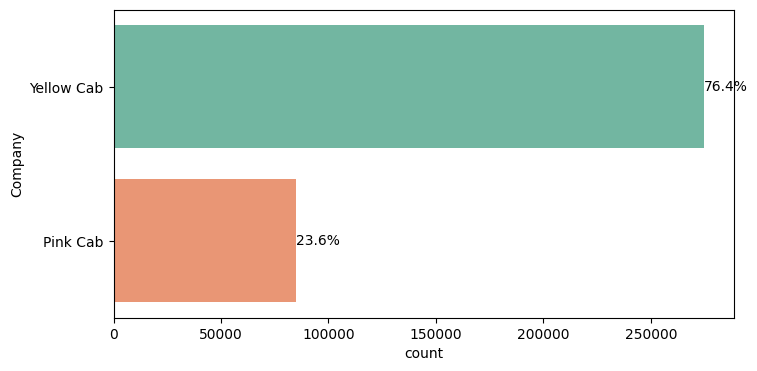

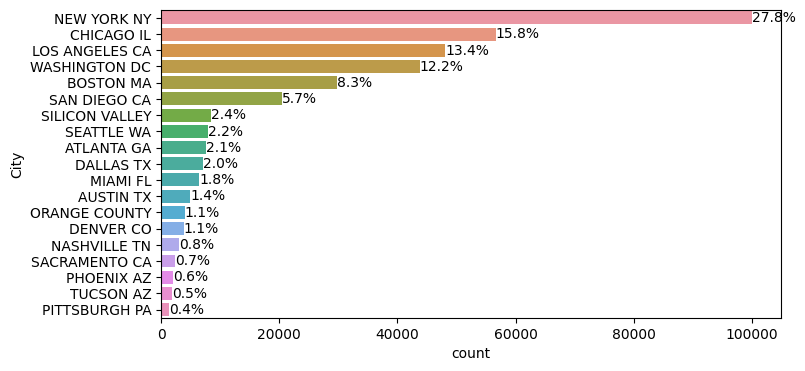

In [13]:
# For 'df_cab'
#######################################

for col in cat_cols1:
    cat_summary(df_cab, col, plot=True)
    
    
#  - "Yellow Cab" dominates with 76.4% of transactions, while "Pink Cab" has 23.6%.
#  - "New York, NY" leads with 27.8% of transactions, followed by "Chicago, IL" with 15.8% and 
#    "Los Angeles, LA" with 13.4%. 

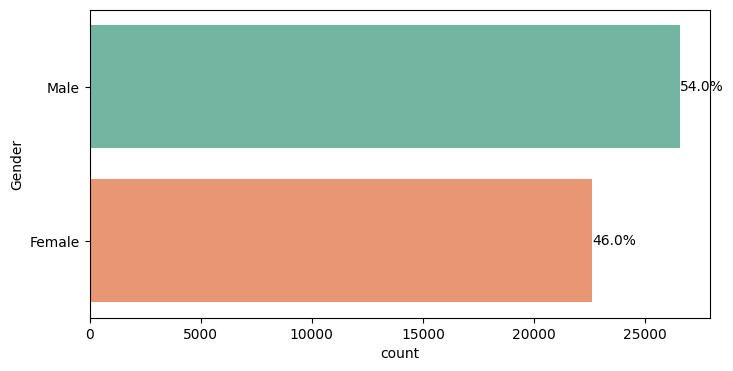

In [14]:
# For 'df_customer'
#######################################

for col in cat_cols2:
    cat_summary(df_customer, col, plot=True)
    
    
#  - Although the majority of customers are seen to be comprised of male customers with 54%, 
#    the number of female customers is also significantly high and should not be underestimated.

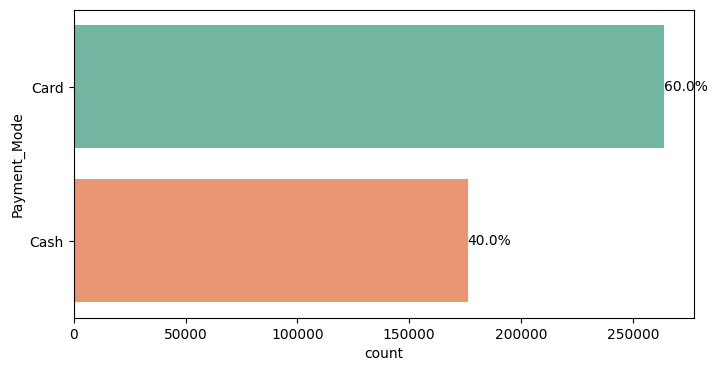

In [15]:
# For 'df_transaction'
#######################################

for col in cat_cols3:
    cat_summary(df_transaction, col, plot=True)
    
    
#  - Transactions are paid by card for 60%, while the remaining amount is paid in cash.

### 2.6. Numerical column summary function

The function visualizes the frequency and percentage of a numerical column.

In [16]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary = dataframe[numerical_col].describe(quantiles)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        
        # Plot histogram
        dataframe[numerical_col].hist(bins=20, ax=axes[0], color="lightblue")
        axes[0].set_xlabel(numerical_col)
        axes[0].set_title(numerical_col)
        
        # Display summary statistics as text
        summary_text = "\n".join([f'{col}: {value:.3f}' for col, value in summary.items()])
        axes[1].text(0.5, 0.5, summary_text, fontsize=12, va='center', ha='left', linespacing=1.5)
        axes[1].axis('off')  # Hide axis for the summary table
        
        plt.show()

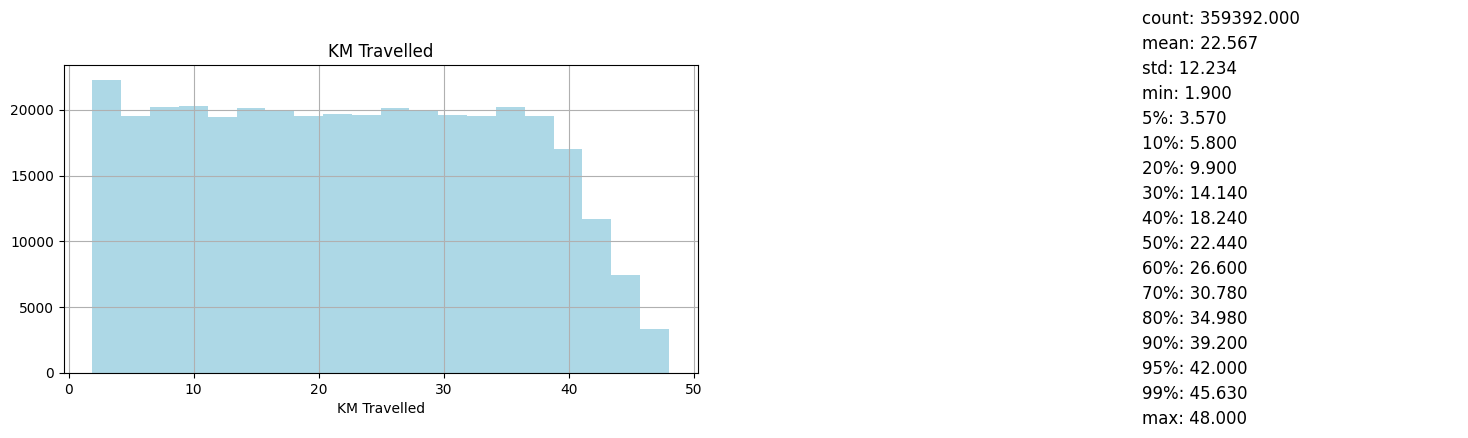

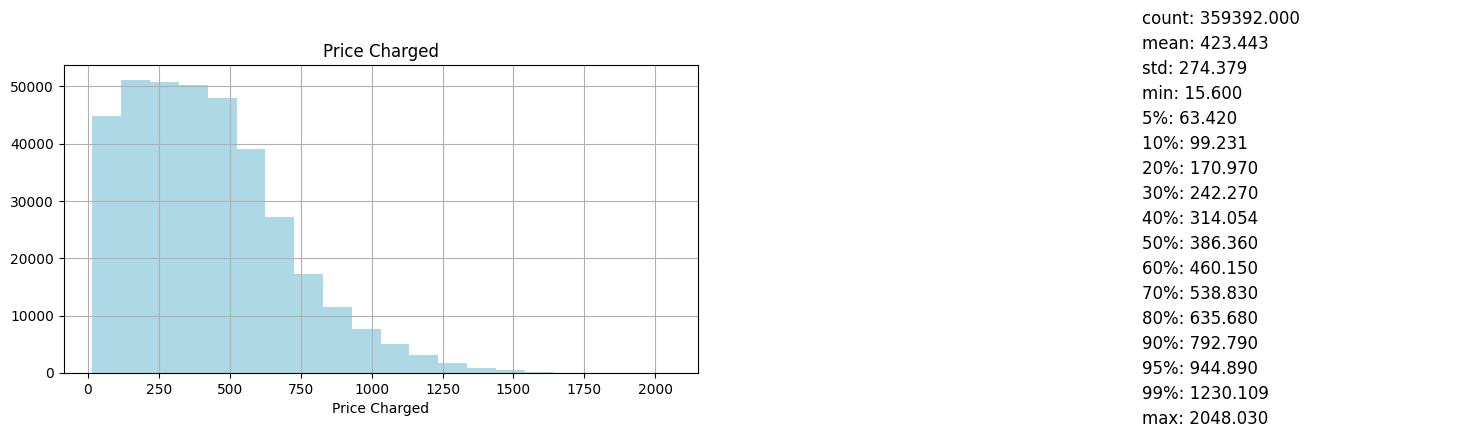

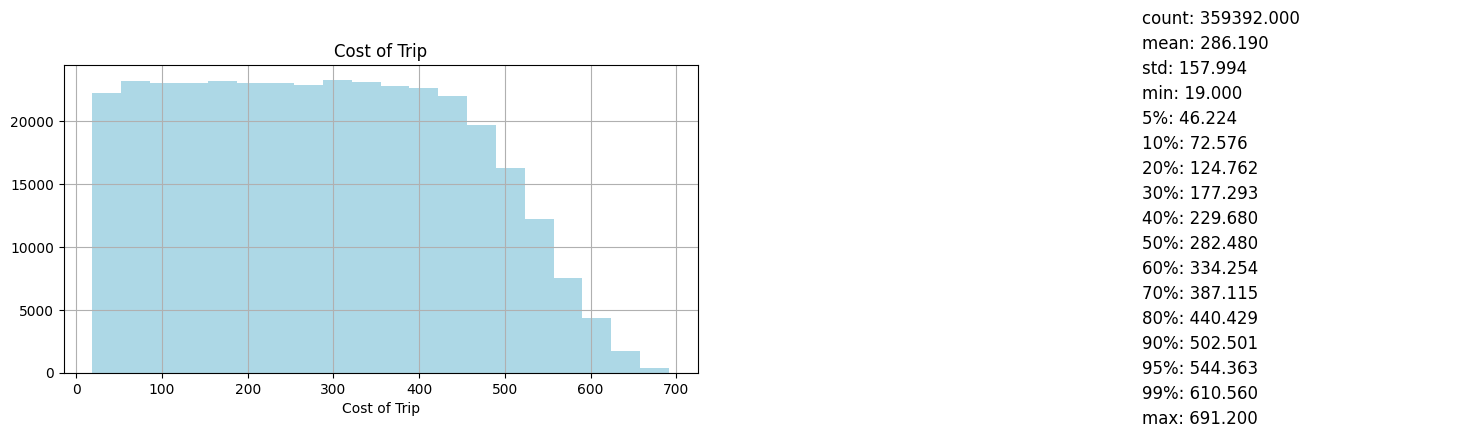

In [17]:
# For 'df_cab'
#######################################

for col in num_cols1:
    num_summary(df_cab, col, plot = True)
    

#  - The closest distance traveled is 1.9 kilometers, while the farthest distance is 48 kilometers.
#  - The price charged exhibits a right-skewed distribution. It can be considered that there might be outliers 
#    due to the right-skewed distribution, as it has been observed that a single transaction paid as high as $2048.
#  - The lowest trip cost is $19 dollars, and the highest is $691.

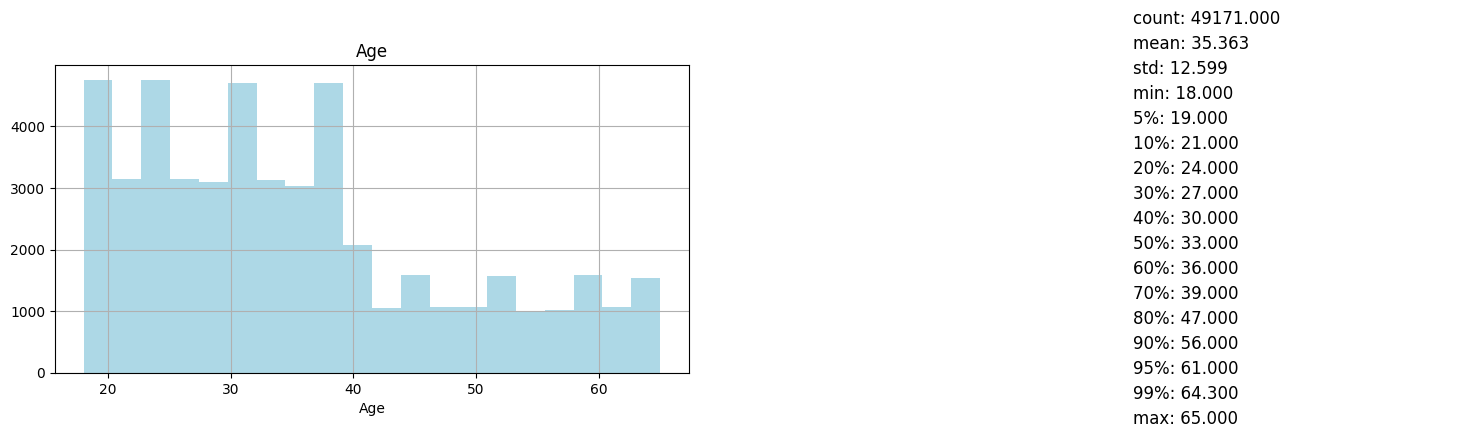

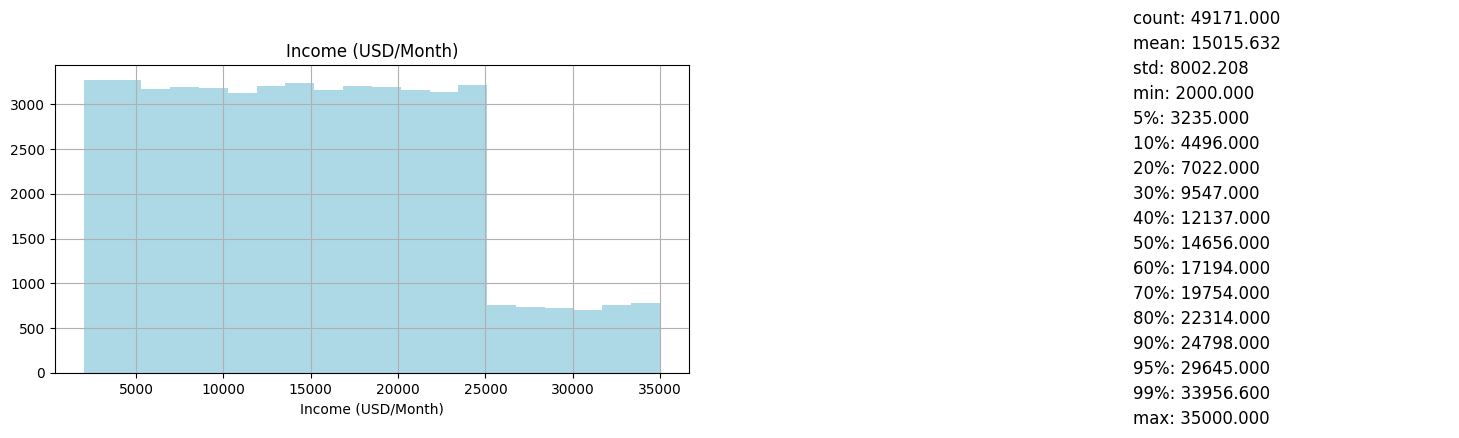

In [18]:
# For 'df_customer'
#######################################

for col in num_cols2:
    num_summary(df_customer, col, plot = True)
    

#  - More than 70% of the customers are below the age of 40, and the oldest customer is 65 years old.
#  - Approximately 10% of the customers have an income exceeding $25,000 per month.

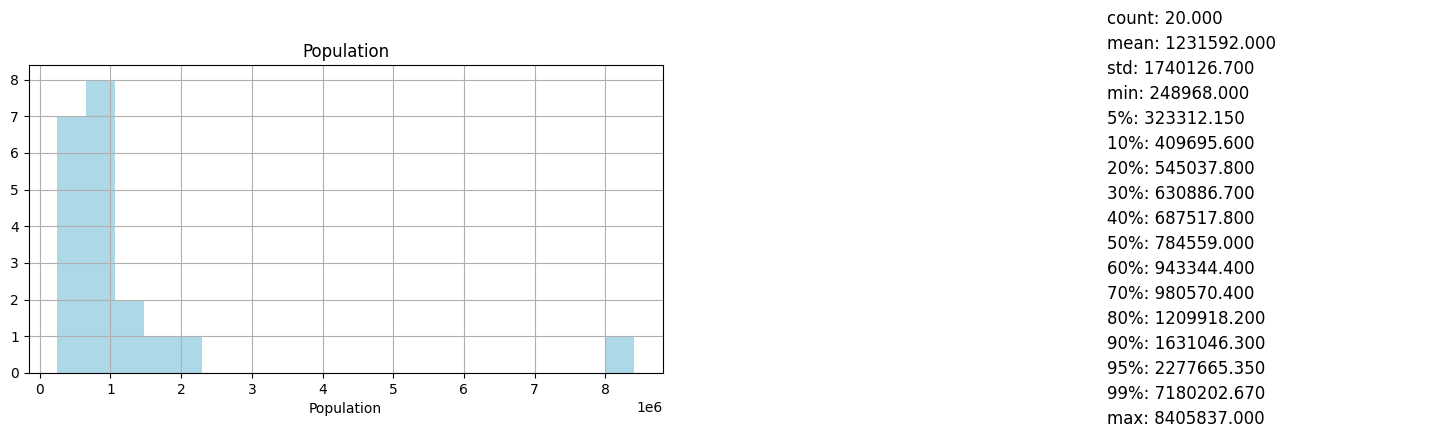

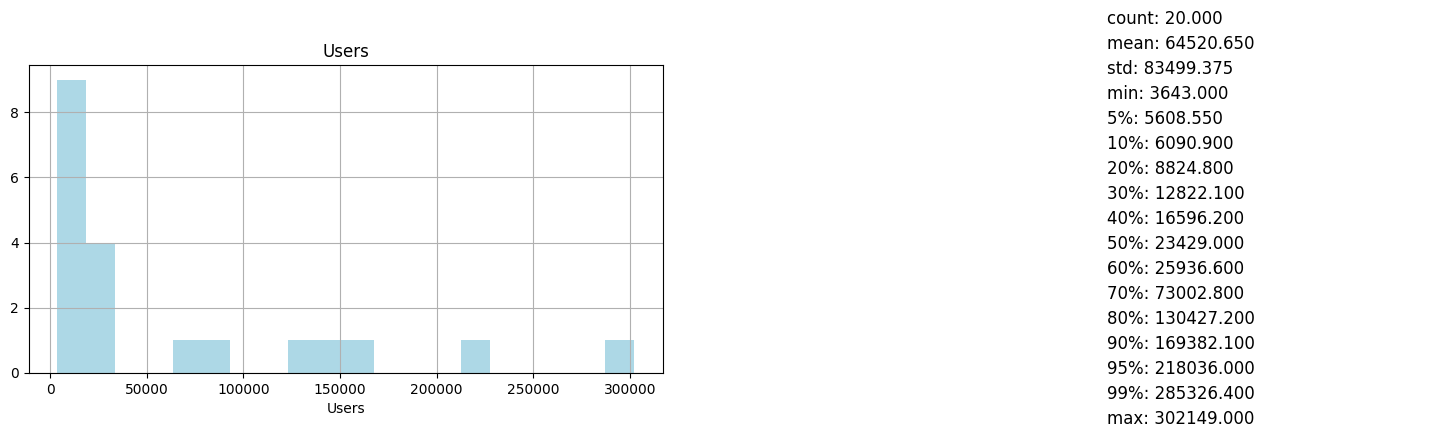

In [19]:
# For 'df_city'
#######################################

for col in num_cols4:
    num_summary(df_city, col, plot = True)
    
    
#  - The city with the lowest population has a population of approximately 250,000, 
#    while the most populous city has a population of around 8.5 million.
#  - Among the cities where cab companies operate, the lowest number of users is 3,643, 
#    and the highest is around 302,000.

### 2.5. Outlier detection:

In this section, we will try to identify outliers in each dataframe and take necessary actions if they exist. 

In [20]:
# The function is used to calculate the outlier thresholds for a specific column in a dataframe.
################################################################
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# This function is designed to check for outliers.
################################################################
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

    
# The function is designed to identify and retrieve outlier data points in a specified column of a dataframe 
# based on predefined outlier thresholds.
################################################################
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    outlier_df = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))]

    if outlier_df.shape[0] > 10:
        print(outlier_df.head())
    else:
        print(outlier_df)

    if index:
        outlier_index = outlier_df.index
        return outlier_index

    return outlier_df.shape[0]


# Outlier suppression function - performs outlier capping for a specific variable within a given dataframe.
################################################################
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

KM Travelled False
Price Charged True
Cost of Trip False


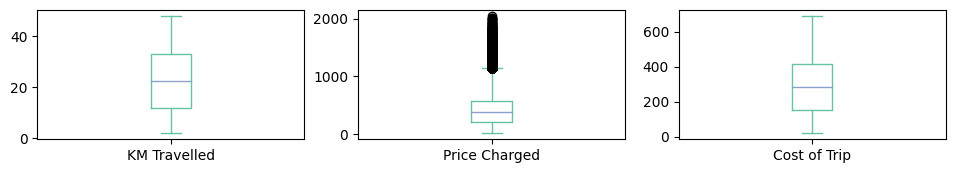

In [21]:
# For 'df_cab'
#######################################

df_cab.plot(kind='box', subplots=True, layout=(20, 5), sharex=False, sharey=False, figsize=(20, 40))

for col in num_cols1:
    print(col, check_outlier(df_cab, col))

    
#  - In this dataset, it can be observed that there are outlier values in the "Price Charged" data.


In [22]:
for col in num_cols1:
    print(col, grab_outliers(df_cab, col))
    
    
# In the "Price Charged" column, there are a total of 22 outlier values. 
# The suppression method will be used for these outliers.

Empty DataFrame
Columns: [Transaction ID, Date of Travel, Company, City, KM Travelled, Price Charged, Cost of Trip]
Index: []
KM Travelled 0
       Transaction ID Date of Travel     Company            City  KM Travelled  Price Charged  Cost of Trip
8159         10010287     2016-02-14  Yellow Cab     NEW YORK NY        47.600       1978.790       651.168
19813        10025091     2016-04-09  Yellow Cab     NEW YORK NY        47.600       1875.110       616.896
24687        10031184     2016-05-01  Yellow Cab     NEW YORK NY        46.400       1893.670       556.800
111171       10136151     2017-01-06  Yellow Cab  SILICON VALLEY        40.950       1878.580       530.712
111180       10136160     2017-01-06  Yellow Cab  SILICON VALLEY        41.340       1908.870       520.884
Price Charged 22
Empty DataFrame
Columns: [Transaction ID, Date of Travel, Company, City, KM Travelled, Price Charged, Cost of Trip]
Index: []
Cost of Trip 0


In [23]:
# The outlier suppression function
for col in num_cols1:
    replace_with_thresholds(df_cab, col)
    
    
# Checking outliers for control
for col in num_cols1:
    print(col, check_outlier(df_cab, col))

KM Travelled False
Price Charged False
Cost of Trip False


Age False
Income (USD/Month) False


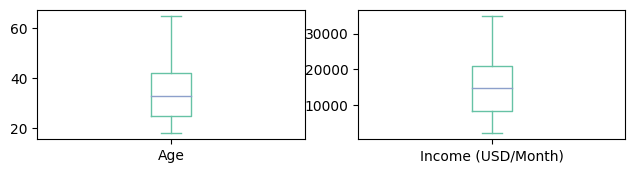

In [24]:
# For 'df_customer'
#######################################

df_customer.plot(kind='box', subplots=True, layout=(20, 5), sharex=False, sharey=False, figsize=(20, 40))

for col in num_cols2:
    print(col, check_outlier(df_customer, col))
    

# There are no outliers in this dataset.

Population True
Users False


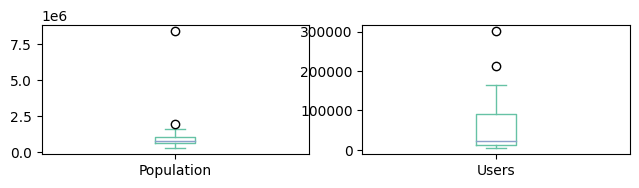

In [25]:
# For 'df_city'
#######################################

df_city.plot(kind='box', subplots=True, layout=(20, 5), sharex=False, sharey=False, figsize=(20, 40))

for col in num_cols4:
    print(col, check_outlier(df_city, col))
    

# In this dataset, there are 2 outliers identified; however, no action has been taken on them.

### 2.6. Correlation heatmap function

This function plots a correlation heatmap for the given dataframe.

In [26]:
def plot_correlation_heatmap(dataframe, threshold=0.5, title="Correlation Heatmap"):
    corr = dataframe.corr()
    high_corr = corr[abs(corr) >= threshold]
    mask = np.triu(np.ones_like(high_corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(4, 3))
    vmin = 0
    vmax = 1.0
    sns.heatmap(high_corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, 
                linewidths=0.5, ax=ax, vmin=vmin, vmax=vmax, cbar_kws={'label': 'Correlation'})
    ax.set_title(title)
    plt.show()


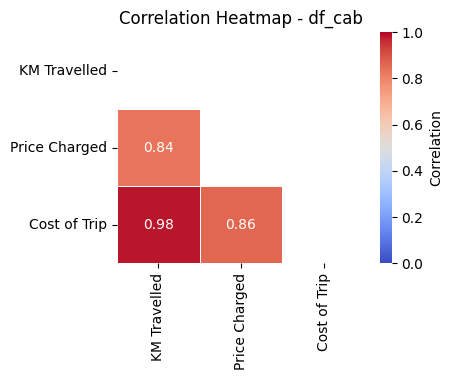

In [27]:
# For 'df_cab'
##############################
plot_correlation_heatmap(df_cab, title="Correlation Heatmap - df_cab")


# The dataset displays notably strong positive correlations among all variables.

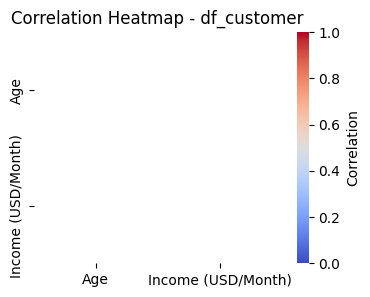

In [28]:
# For 'df_customer'
##############################
plot_correlation_heatmap(df_customer, title="Correlation Heatmap - df_customer")


# There is no relationship between the ages of customers and their monthly incomes.

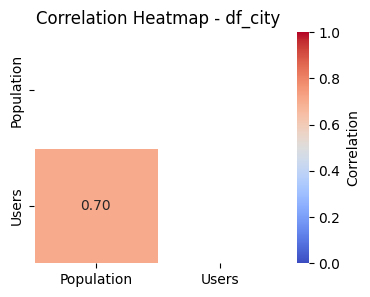

In [29]:
# For 'df_city'
##############################
plot_correlation_heatmap(df_city, title="Correlation Heatmap - df_city")


# The correlation coefficient between city populations and the number of cab service users is positive (R = 0.70).

## 3. Hypotheses and Recommendations

In this section, the accuracy of various hypotheses will be tested, and based on the results obtained, recommendations will be provided to the customer.

### Merging dataframes:

In [30]:
# 1. Merge the df_cab and df_transaction dataframes on the 'Transaction ID' column
df_cab_trs = df_cab.merge(df_transaction, on='Transaction ID', how='left')

# 2. Merge customer data with the merged cab and transaction data based on 'Customer ID'
df = df_cab_trs.merge(df_customer, on='Customer ID', how='left')

# 3. Merge the 'Users' from df_city to df based on the 'City' column
df = df.merge(df_city[['City', 'Users']], on='City', how='left')

In [31]:
check_df(df)

,0
Transaction ID,object
Date of Travel,object
Company,object
City,object
KM Travelled,float64
Price Charged,float64
Cost of Trip,float64
Customer ID,object
Payment_Mode,object
Gender,object


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Users
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.450,370.950,313.635,29290,Card,Male,28,10813,24701.000
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.620,358.520,334.854,27703,Card,Male,27,9237,24701.000
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.040,125.200,97.632,28712,Cash,Male,53,11242,24701.000
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.170,377.400,351.602,28020,Cash,Male,23,23327,24701.000
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.730,114.620,97.776,27182,Card,Male,33,8536,24701.000


,0
Transaction ID,0
Date of Travel,0
Company,0
City,0
KM Travelled,0
Price Charged,0
Cost of Trip,0
Customer ID,0
Payment_Mode,0
Gender,0


,count,mean,std,min,25%,50%,95%,max
KM Travelled,359392.000,22.567,12.234,1.900,12.000,22.440,42.000,48.000
Price Charged,359392.000,423.438,274.349,15.600,206.438,386.360,944.890,1833.128
Cost of Trip,359392.000,286.190,157.994,19.000,151.200,282.480,544.363,691.200
Age,359392.000,35.337,12.594,18.000,25.000,33.000,61.000,65.000
Income (USD/Month),359392.000,15048.823,7969.409,2000.000,8424.000,14685.000,29659.000,35000.000
Users,359392.000,158365.582,100850.051,3643.000,80021.000,144132.000,302149.000,302149.000


In [32]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 359392
Variables: 13
cat_cols: 4
num_cols: 6
cat_but_car: 3
num_but_cat: 0


### Assumptions checking for hypotheses:

- This section encompasses important steps performed prior to data analysis. 
- Functions below check the normality assumption of the data using the Shapiro-Wilk test and the homogeneity of variance using the Levene test before hypothesis tests.
- If both assumptions (normality and homogeneity) are met, a parametric test is conducted.
- If the normal distribution assumption is not met, non-parametric tests are conducted.
- If normality is met but homogeneity is not, a parametric test can be conducted with the 'equal_var = False' argument.

In [33]:
# Assumption of normality
##############################################
def shapiro_test(x, y):
    test_stat_x, pvalue_x = shapiro(x)
    test_stat_y, pvalue_y = shapiro(y)
    if pvalue_x < 0.05:
        print('Test Stat = %.4f, p-value = %.4f' % (test_stat_x, pvalue_x),
              'HO is rejected, the assumption of normal distribution is not satisfied')
    else:
        print('Test Stat = %.4f, p-value = %.4f' % (test_stat_x, pvalue_x),
              'HO is not rejected, the assumption of normal distribution is satisfied')
        

    
# Assumption of homogeneity of variance
##############################################
def levene_test(x,y):
    test_stat, pvalue = levene(x, y)
    if pvalue < 0.05:
        print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue),
              'HO is rejected, the homogeneity of variance is not satisfied')
    else:
        print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue),
              'HO is not rejected, the homogeneity of variance is satisfied')

### Market shares of companies by cities:

City-based market share analysis is crucial for determining the success and growth opportunities of cab companies and is essential for strategic planning and investments.

NOTE: In the 'df_city' dataset, despite the presence of 'San Francisco CA' as a city, there are no transactions or records associated with this city in the 'df_cab' dataset.


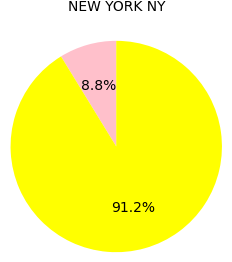
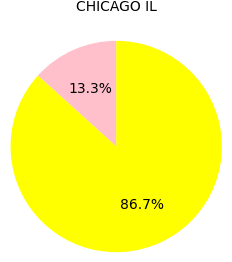
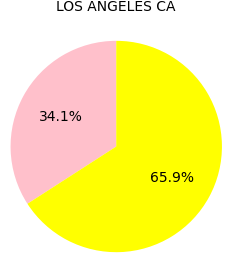
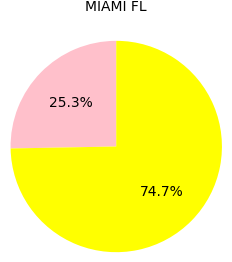
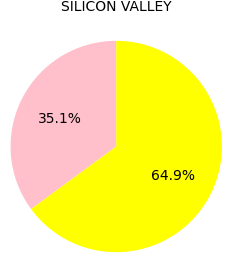
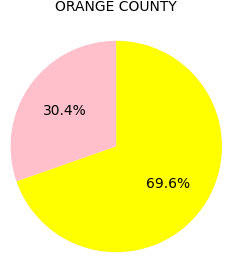
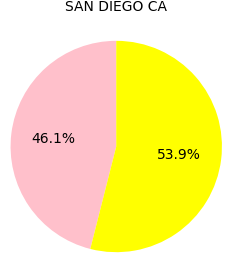
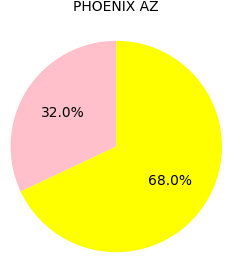
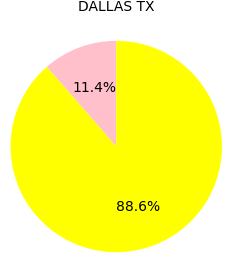
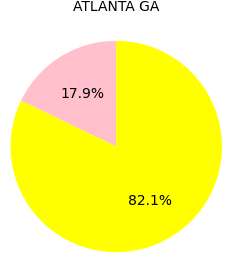
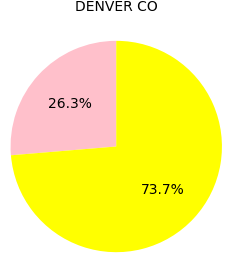
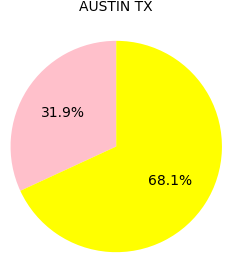
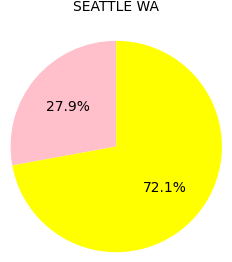
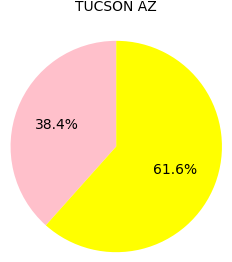
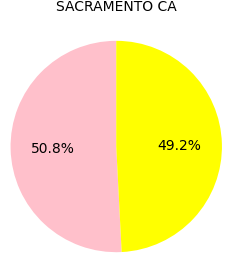
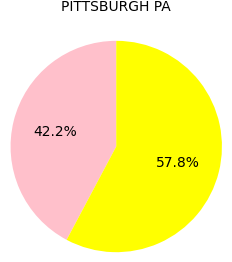
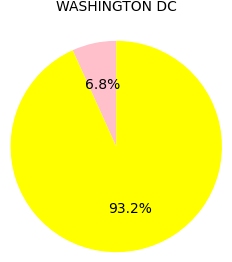
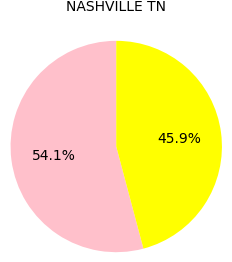
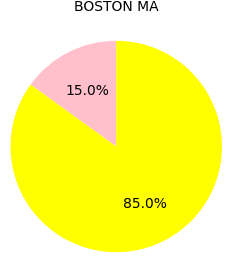

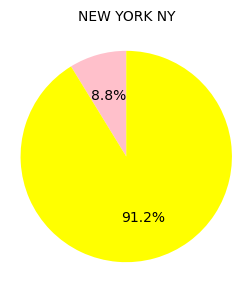

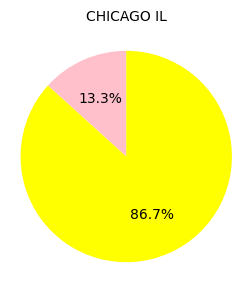

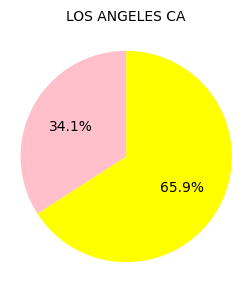

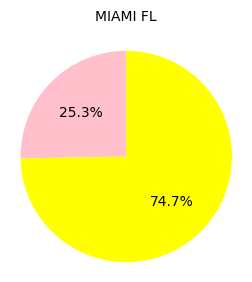

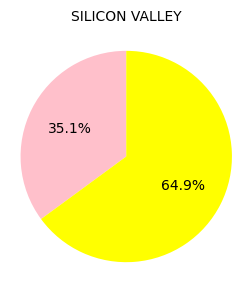

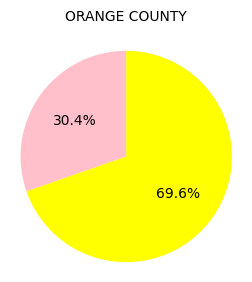

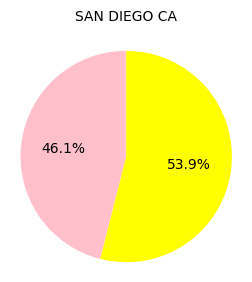

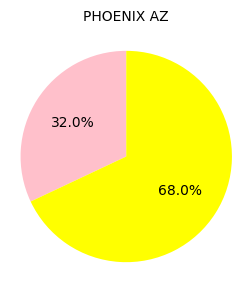

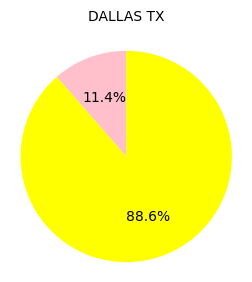

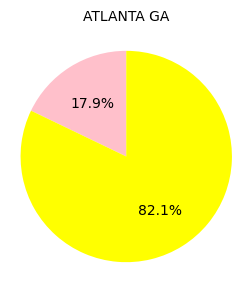

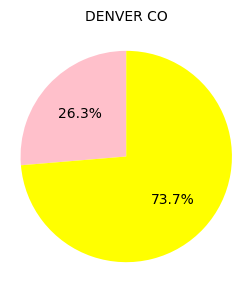

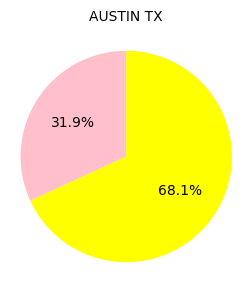

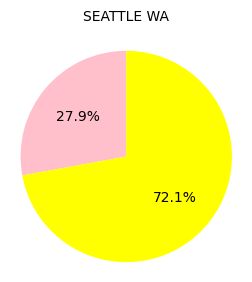

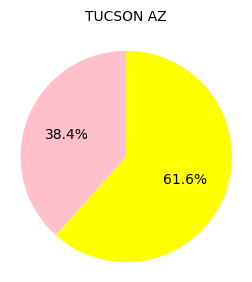

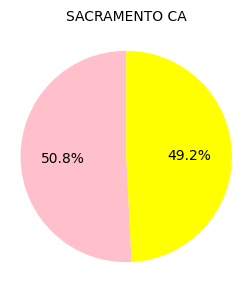

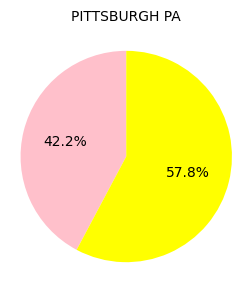

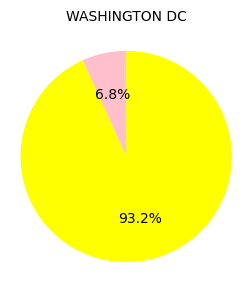

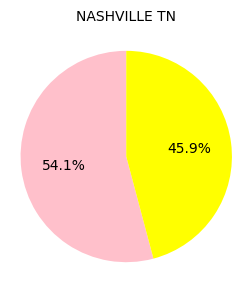

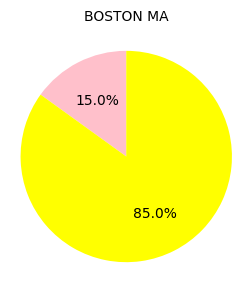

In [34]:
us_map = folium.Map(location=[37, -95], zoom_start=4)

for index, row in df_coordinates.iterrows():
    city = row['City']
    coords = ast.literal_eval(row['Coordinates'])
    city_data = df[df['City'] == city]
    
    total_revenue = city_data['Price Charged'].sum()
    
    pink_cab_revenue = city_data[city_data['Company'] == 'Pink Cab']['Price Charged'].sum()
    yellow_cab_revenue = city_data[city_data['Company'] == 'Yellow Cab']['Price Charged'].sum()
    
    pink_cab_percentage = (pink_cab_revenue / total_revenue) * 100
    yellow_cab_percentage = (yellow_cab_revenue / total_revenue) * 100

    labels = ['', '']
    sizes = [pink_cab_percentage, yellow_cab_percentage]
    colors = ['pink', 'yellow']
    fig1, ax1 = plt.subplots(figsize=(3, 3))
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')

    plt.title(city, fontsize=10, pad=15, color='black')

    graph_io = BytesIO()
    plt.savefig(graph_io, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    graph_io.seek(0)

    graph_encoded = base64.b64encode(graph_io.read()).decode()
    graph_html = f'<img src="data:image/png;base64,{graph_encoded}">'

    folium.Marker(
        location=coords,
        popup=folium.Popup(html=graph_html, max_width=300),
    ).add_to(us_map)

us_map


- Except for Sacramento, CA, and Nashville, TN, Yellow Cab dominates the market in all other cities. 
- Yellow Cab has a significantly high market share on the eastern coast, while Pink Cab's revenues have slightly increased in the western regions.

### 3.1. Hypothesis 1: Average profit per kilometer

- H0: There is no difference in the average profit per km between Yellow Cab and Pink Cab.
- H1: There is a significant difference in the average profit per km between Yellow Cab and Pink Cab.

In [35]:
# Adding a new column 'Profit' to 'df_cab' dataset
#############################################
df['Profit'] = df['Price Charged'] - df['Cost of Trip']
df['Profit per KM'] = df['Profit'] / df['KM Travelled']


# Calculate the average profit of companies
#############################################
average_profit_per_km = df.groupby('Company')['Profit per KM'].mean()
average_profit_per_km

Company
Pink Cab     2.770
Yellow Cab   7.105
Name: Profit per KM, dtype: float64

"Pink Cab" makes an average profit of 2.8 dollars per transaction, while "Yellow Cab" makes 7.11 dollars in profit per KM.

In [36]:
# The profits of 'Pink Cab' and 'Yellow Cab'
#############################################
pink_cab_profits = df[df['Company'] == 'Pink Cab']['Profit per KM']
print(len(pink_cab_profits))

yellow_cab_profits = df[df['Company'] == 'Yellow Cab']['Profit per KM']
print(len(yellow_cab_profits))

84711
274681


Although the data set sizes are unevenly distributed, indicating that non-parametric tests may be more appropriate, it will also be checked whether the assumptions are met.

In [37]:
# Assumptions
#############################################

# Normality
shapiro_test(pink_cab_profits, yellow_cab_profits)

# Homogeneity of variance
levene_test(pink_cab_profits, yellow_cab_profits)

Test Stat = 0.9595, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 35372.9118, p-value = 0.0000 HO is rejected, the homogeneity of variance is not satisfied


Since the assumptions are not met, a non-parametric test, namely the Mann-Whitney U test, will be conducted.

In [38]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(pink_cab_profits, yellow_cab_profits)

Test Stat = 6173556829.0000, p-value = 0.0000 HO is rejected, there is a statistically significant difference between the groups


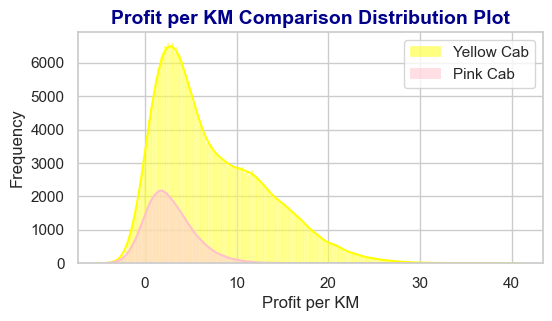

In [39]:
# Creating a Profit Distribution Plot
#####################################
sns.set(style="whitegrid")
plt.figure(figsize=(6, 3))

sns.histplot(yellow_cab_profits, color='yellow', label='Yellow Cab', kde=True)
sns.histplot(pink_cab_profits, color='pink', label='Pink Cab', kde=True)

plt.xlabel('Profit per KM')
plt.ylabel('Frequency')
plt.title('Profit per KM Comparison Distribution Plot', fontsize=14, fontweight='bold', color='darkblue')
plt.legend()

plt.show()

In the distrubiton plot, the difference in profit per kilometer between the companies is quite significant. Additionally, it can be observed that both companies have incurred losses in some transactions. 

Below, first, the profit per kilometer values for the companies by cities will be examined, and then the loss rates will be analyzed.

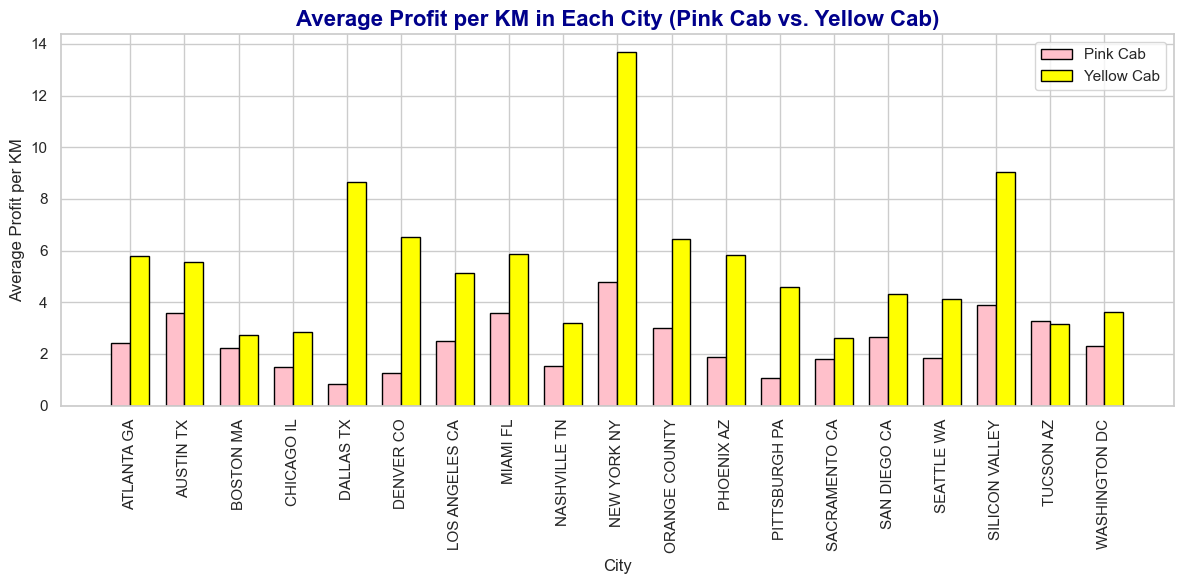

In [40]:
# Average profit per KM in each city
#####################################
city_avg_profit_per_km = df.groupby(['City', 'Company'])['Profit per KM'].mean().unstack()

cities = city_avg_profit_per_km.index

# Creating graph
################
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(cities))

bar1 = ax.bar(index, city_avg_profit_per_km['Pink Cab'], bar_width, label='Pink Cab', color='pink', edgecolor='black')

bar2 = ax.bar(index + bar_width, city_avg_profit_per_km['Yellow Cab'], bar_width, label='Yellow Cab', color='yellow', edgecolor='black')

ax.set_xlabel('City')
ax.set_ylabel('Average Profit per KM')
ax.set_title('Average Profit per KM in Each City (Pink Cab vs. Yellow Cab)', fontsize=16, fontweight='bold', color='darkblue')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(cities, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

- In all cities except Tucson AZ, the average profit per kilometer for Yellow Cab is higher than Pink Cab. 
- In New York NY, Dallas TX, and Silicon Valley, the average profit per kilometer of Yellow Cab exceeds 8 dollars.

In [41]:
# Counting the transactions with no profit or loss grouped by companies
########################################################################
no_profit_or_loss_by_company = df[df['Profit per KM'] <= 0].groupby('Company')['Transaction ID'].count()


# Calculating the total transaction count for each company
total_transactions_by_company = df.groupby('Company')['Transaction ID'].count()


# Calculating the percentage of transactions with no profit or loss relative to the total transactions
percentage_no_profit_or_loss_by_company = (no_profit_or_loss_by_company / total_transactions_by_company) * 100


result_df = pd.DataFrame({'No Profit or Loss Count': no_profit_or_loss_by_company, 'Total Transaction Count': total_transactions_by_company, 'Percentage': percentage_no_profit_or_loss_by_company})
result_df.head()


,No Profit or Loss Count,Total Transaction Count,Percentage
Company,,,
Pink Cab,11131,84711,13.140
Yellow Cab,13692,274681,4.985


For Yellow Cab, approximately 5% of the transactions result in no profit or a loss, whereas for Pink Cab, this percentage is around 13%. This means that for Pink Cab, the percentage is more than 2.5 times that of Yellow Cab.

The analysis below examines how this situation varies across different cities.

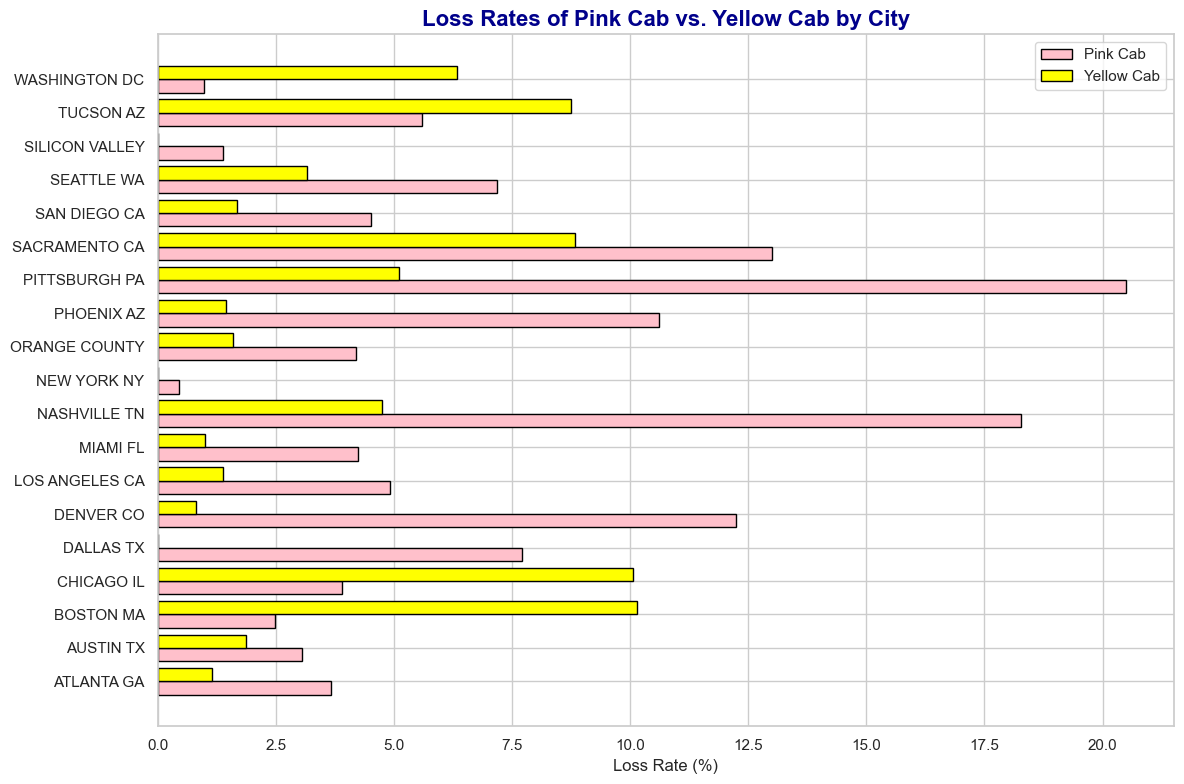

In [42]:
# Counting the transactions with no profit or loss grouped by companies and cities
##################################################################################
loss_by_city_company = df[df['Profit per KM'] <= 0].groupby(['Company', 'City'])['Transaction ID'].count()


# Calculating the total transaction count for each city
total_transactions_by_city = df.groupby('City')['Transaction ID'].count()


# Calculating the percentage of loss for each company in each city
percentage_loss_by_city_company = (loss_by_city_company / total_transactions_by_city) * 100

result_df2 = percentage_loss_by_city_company.unstack(fill_value=0)


# Plotting graph
################
cities = result_df2.columns
pink_cab_loss_rates = result_df2.loc['Pink Cab']
yellow_cab_loss_rates = result_df2.loc['Yellow Cab']

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(cities))

bar1 = ax.barh(index - bar_width / 2, pink_cab_loss_rates, bar_width, label='Pink Cab', color='pink', edgecolor='black')

bar2 = ax.barh(index + bar_width / 2, yellow_cab_loss_rates, bar_width, label='Yellow Cab', color='yellow', edgecolor='black')

ax.set_xlabel('Loss Rate (%)')
ax.set_title('Loss Rates of Pink Cab vs. Yellow Cab by City', fontsize=16, fontweight='bold', color='darkblue')
ax.set_yticks(index)
ax.set_yticklabels(cities)
ax.legend()

plt.tight_layout()
plt.show()

- The loss rate of Yellow Cab is higher than Pink Cab in four cities, which are Boston MA, Chicago IL, Tucson AZ, and Washington DC. 
- In all other cities, the loss rate of Pink Cab is higher, and it is particularly noteworthy that the rates are above 18% in Pittsburgh PA and Nashville TN. Despite having such a high loss rate in Nashville TN, the market share advantage being with Pink Cab is remarkable.

### 3.2. Hypothesis 2: Number of loyal customers

- H0: There is no difference in loyal customer count between Pink Cab and Yellow Cab.
- H1: There is a difference in loyal customer count between Pink Cab and Yellow Cab.

In [43]:
# Total number of customers
###########################
df['Customer ID'].nunique()

46148

In [44]:
# Number of customers for each company
######################################
pink_cab_customers = df[df['Company'] == 'Pink Cab']['Customer ID'].nunique()
print("Number of Pink Cab Customers:", pink_cab_customers)

yellow_cab_customers = df[df['Company'] == 'Yellow Cab']['Customer ID'].nunique()
print("Number of Yellow Cab Customers:", yellow_cab_customers)

common_customers = len(set(df[df['Company'] == 'Pink Cab']['Customer ID']).intersection(set(df[df['Company'] == 'Yellow Cab']['Customer ID'])))
print("Number of Common Customers:", common_customers)

Number of Pink Cab Customers: 32330
Number of Yellow Cab Customers: 39896
Number of Common Customers: 26078


In [45]:
# Calculating the number of transactions
##########################################
customer_usage = df.groupby(['Customer ID', 'Company'])['Transaction ID'].count().reset_index()

pivot_table = customer_usage.pivot(index='Customer ID', columns='Company', values='Transaction ID')

pivot_table = pivot_table.fillna(0)

pivot_table['Total Transactions'] = pivot_table.sum(axis=1)

pivot_table.head()


Company,Pink Cab,Yellow Cab,Total Transactions
Customer ID,,,
1,4.000,25.000,29.000
10,3.000,21.000,24.000
100,4.000,35.000,39.000
1000,6.000,27.000,33.000
10000,0.000,2.000,2.000


### RFM Analysis

RFM analysis is a method used to classify customers and identify the most valuable ones by considering **Recency** (recentness), **Frequency** (frequency), and **Monetary** (monetary) factors. 

Separate RFM analyses will be conducted for both companies to calculate the total number of loyal customers. 

This analysis will allow for the evaluation of the quality of each company's customer base.

In [46]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

url = "https://cdn.enhencer.com/website-assets/images/blog/AdvantagesAndInefficaciesOfRFMSegmentation1.png"
Image(url=url, width=600, height=400)

In this section, the focus will be on the 'Champions' and 'Loyal Customers' segments as seen in the above chart.

In [47]:
# Separating customers according to company
###########################################
pink_cab_customers = df[df['Company'] == 'Pink Cab']

yellow_cab_customers = df[df['Company'] == 'Yellow Cab']

In [48]:
# Choosing analysis date
########################
df["Date of Travel"].max()
# datetime.date(2018, 12, 31)


# The analysis date has been selected as two days after the date above.
analysis_date = dt.datetime(2019, 1, 2)

### a)  RFM - Pink Cab

In [49]:
pink_cab_customers['Date of Travel'] = pd.to_datetime(pink_cab_customers['Date of Travel'])

# Calculate RFM metrics for Pink Cab customers
##############################################
rfm_pink = pink_cab_customers.groupby('Customer ID').agg({'Date of Travel': lambda x: (analysis_date - x.max()).days,
                                                         'Transaction ID': lambda x: x.nunique(),
                                                         'Price Charged': lambda x: x.sum()})

rfm_pink.columns = ['recency', 'frequency', 'monetary']
rfm_pink.head()

rfm_pink.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,32330.000,340.657,292.521,2.000,81.000,272.000,517.000,1096.000
frequency,32330.000,2.620,2.194,1.000,1.000,2.000,3.000,18.000
monetary,32330.000,814.360,762.878,15.600,294.532,543.455,1092.140,6568.900


- **Recency:** On average, customers transact every 340.66 days, with a range from 2 days to 3 years.
- **Frequency:** Customers make an average of 2.62 transactions, ranging from 1 to 18 transactions. About half of them make 2 transactions on average.
- **Monetary:** On average, customers spend 814.36 dollars, with spending ranging from 15.60 to 6568.90 dollars.

In [50]:
# Calculate RFM scores for Pink Cab customers (between 1 and 5)
################################################################
rfm_pink["recency_score"] = pd.qcut(rfm_pink['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_pink["frequency_score"] = pd.qcut(rfm_pink['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_pink["monetary_score"] = pd.qcut(rfm_pink['monetary'], 5, labels=[1, 2, 3, 4, 5])


rfm_pink["RFM_SCORE"] = (rfm_pink['recency_score'].astype(str) + rfm_pink['frequency_score'].astype(str))

rfm_pink['segment'] = rfm_pink['RFM_SCORE'].replace(seg_map, regex=True)

rfm_pink.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
1,388,4,2286.480,2,4,5,24,at_Risk
10,157,3,1001.490,4,4,4,44,loyal_customers
100,439,4,1934.620,2,4,5,24,at_Risk
1000,72,6,2813.150,4,5,5,45,loyal_customers
10001,33,1,28.650,5,1,1,51,new_customers


In [51]:
# Number of 'Champions' and 'Loyal Customers' - Pink Cab
########################################################
segment_counts = rfm_pink.groupby('segment').size()

champions_and_loyal_customers_count_p = segment_counts.loc[['champions', 'loyal_customers']].sum()

print("Champions and Loyal Customers Count of Pink Cab:", champions_and_loyal_customers_count_p)


Champions and Loyal Customers Count of Pink Cab: 10923


### b)  RFM - Yellow Cab

In [52]:
yellow_cab_customers['Date of Travel'] = pd.to_datetime(yellow_cab_customers['Date of Travel'])

# Calculate RFM metrics for Yellow Cab customers
################################################
rfm_yellow = yellow_cab_customers.groupby('Customer ID').agg({'Date of Travel': lambda x: (analysis_date - x.max()).days,
                                                         'Transaction ID': lambda x: x.nunique(),
                                                         'Price Charged': lambda x: x.sum()})

rfm_yellow.columns = ['recency', 'frequency', 'monetary']
rfm_yellow.head()

rfm_yellow.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,39896.000,262.796,279.443,2.000,40.000,133.000,425.000,1096.000
frequency,39896.000,6.885,8.183,1.000,1.000,3.000,10.000,47.000
monetary,39896.000,3154.500,4601.930,24.790,556.057,1260.965,3895.115,32351.360


- **Recency:** Customers transact, on average, every 263 days, with a range from 2 days to 3 years.
- **Frequency:** On average, customers make 6.88 transactions, ranging from 1 to 47 transactions.
- **Monetary:** Customers spend an average of 3154.50 units, with spending ranging from 24.79 to 32351.36 units.

In [53]:
# Calculate RFM scores for Yellow Cab customers (between 1 and 5)
################################################################
rfm_yellow["recency_score"] = pd.qcut(rfm_yellow['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_yellow["frequency_score"] = pd.qcut(rfm_yellow['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_yellow["monetary_score"] = pd.qcut(rfm_yellow['monetary'], 5, labels=[1, 2, 3, 4, 5])


rfm_yellow["RFM_SCORE"] = (rfm_yellow['recency_score'].astype(str) + rfm_yellow['frequency_score'].astype(str))

rfm_yellow['segment'] = rfm_yellow['RFM_SCORE'].replace(seg_map, regex=True)

rfm_yellow.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
1,17,25,15203.650,5,5,5,55,champions
10,11,21,11906.240,5,5,5,55,champions
100,14,35,21660.870,5,5,5,55,champions
1000,39,27,14081.770,4,5,5,45,loyal_customers
10000,365,2,963.070,2,2,3,22,hibernating


In [54]:
# Number of 'Champions' and 'Loyal Customers' - Yellow Cab
##########################################################
segment_counts = rfm_yellow.groupby('segment').size()

champions_and_loyal_customers_count_y = segment_counts.loc[['champions', 'loyal_customers']].sum()

print("Champions and Loyal Customers Count of Yellow Cab:", champions_and_loyal_customers_count_y)


Champions and Loyal Customers Count of Yellow Cab: 14812


In Pink Cab, the number of customers in the "Loyal Customers" and "Champions" segments is 10,923 (%33.8), while in Yellow Cab, this number is 14,812 (%37.1). Therefore, the null hypothesis (H0) is rejected, and it can be stated that there is a difference between them.

**Note:** Based on the findings of these RFM analyses, specific marketing strategies and campaigns can be tailored to target each customer segment effectively.

### 3.3. Hypothesis 3:  Expected transaction count for 12 months

- H0: The expected transaction count for Yellow Cab and Pink Cab companies is the same over a 12-month period.
- H1: The expected transaction count for Yellow Cab and Pink Cab companies is different over a 12-month period.

In this section, we will use the BG/NBD model to calculate the expected transaction counts for companies after one year, and in addition to that, various analyses related to customers will be conducted.

In [55]:
# Annual transaction count of each company
##########################################
yearly_transaction_counts = df.groupby(['Company', pd.to_datetime(df['Date of Travel']).
                                        dt.year])['Transaction ID'].count().reset_index()
yearly_transaction_counts.rename(columns={'Transaction ID': 'Yearly Transaction Count'}, inplace=True)

year_company = yearly_transaction_counts.pivot_table(index='Company', columns='Date of Travel', 
                                                     values='Yearly Transaction Count', fill_value=0)
year_company

Date of Travel,2016,2017,2018
Company,,,
Pink Cab,25080,30321,29310
Yellow Cab,82239,98189,94253


In 2017, both companies reached their highest transaction counts, and throughout all years, Yellow Cab's transaction count is more than three times that of Pink Cab.

In [56]:
# Expected transaction count for 12 months function
###################################################
def exp_trs_count(dataframe, analysis_date):
    
    # Calculate Recency, T (customer age), frequency, and monetary values
    df = dataframe.groupby('Customer ID').agg(
        recency=('Date of Travel', lambda x: (x.max() - x.min()).days),
        T=('Date of Travel', lambda x: (analysis_date - x.min()).days),
        frequency=('Transaction ID', 'nunique')
    )

    
    # Update the Recency and T columns in weeks
    df["recency"] =  df["recency"] // 7
    df["T"] =  df["T"] // 7
    df =  df[( df['frequency'] > 1)] # Customers who have used the cab company multiple times
    
    # BetaGeoFitter model
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit( df['frequency'], 
             df['recency'],  
             df['T'])
    
    
    # Calculate the estimated total transaction amount for a 12-month period
    expected_transactions_12_month = bgf.predict(4 * 12, 
                                              df['frequency'], 
                                              df['recency'], 
                                              df['T']).sum()
    plot_frequency_recency_matrix(bgf)
    plt.show()
    
    return expected_transactions_12_month


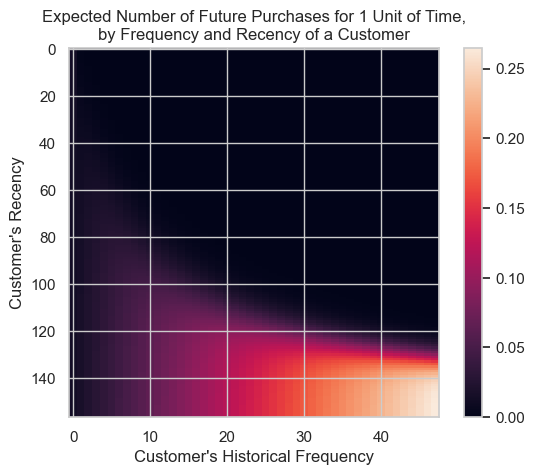

Expected Transactions in 12 Months for Yellow Cab: 93243.11693031699


In [57]:
# Yellow Cab
#################
yellow_result = exp_trs_count(yellow_cab_customers, analysis_date)
# analysis_date = dt.datetime(2019, 1, 2)

print("Expected Transactions in 12 Months for Yellow Cab:", yellow_result)

- In the graph, customers who have used a yellow cab more than 40 times and made their latest purchase when they were more than 130 months old (bottom right) stand out as the most active and likely to continue using the service.

- On the contrary, the coldest customers are in the top right corner, and we haven’t seen them in months.

- Also, expected purchases in 1 year for Yellow Cab is 93.243, and this value is quite close to the transaction counts from previous years.

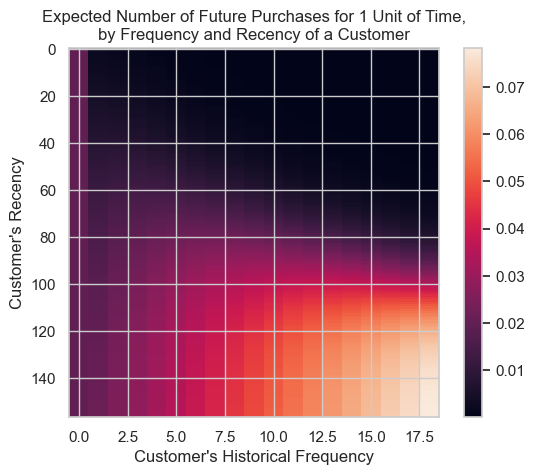

Expected Transactions in 12 Months for Pink Cab: 27900.698027003265


In [58]:
# Pink Cab
#################
pink_result = exp_trs_count(pink_cab_customers, analysis_date)
# analysis_date = dt.datetime(2019, 1, 2)

print("Expected Transactions in 12 Months for Pink Cab:", pink_result)

- It has been observed that Pink Cab has its hottest customers with approximately 110 months of recency and around 17 in frequency. 
- Additionally, the expected transaction count at the end of 12 months is 27,900. 

It is anticipated that the transaction counts for both companies will **decrease** compared to the previous year (2018).

In [60]:
# Cross validation
##################
def fit_and_plot_bgf(dataframe, calibration_end_date, observation_end_date, penalizer_coef=0.1):
    # Create calibration and holdout data
    summary_cal_holdout = calibration_and_holdout_data(
        dataframe,
        "Customer ID",
        "Date of Travel",
        calibration_period_end=calibration_end_date,
        observation_period_end=observation_end_date
    )
    
    # Create a BG/NBD model
    bgf = BetaGeoFitter(penalizer_coef=0.1)
    
    # Fit the model to the data
    bgf.fit(summary_cal_holdout['frequency_cal'], 
            summary_cal_holdout['recency_cal'], 
            summary_cal_holdout['T_cal'])
    
    # Plot calibration purchases versus holdout purchases
    plt.figure(figsize=(10, 6))
    plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
    plt.xlabel("Expected Purchases (Calibration Period)")
    plt.ylabel("Actual Purchases (Holdout Period)")
    plt.title("Calibration Purchases vs. Holdout Purchases")
    plt.show()

<Figure size 1000x600 with 0 Axes>

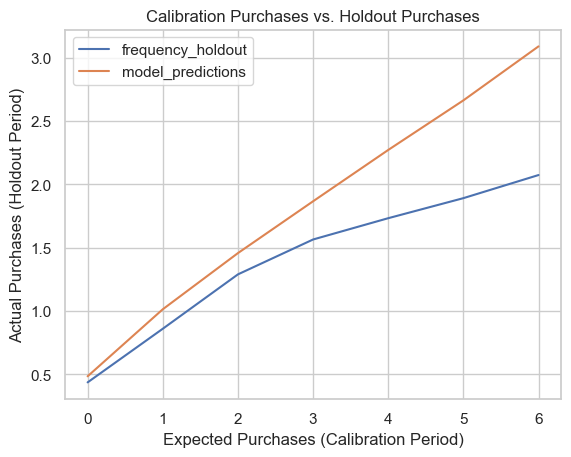

In [61]:
# Pink Cab 
##########
fit_and_plot_bgf(pink_cab_customers, '2018-01-02', '2018-12-31', penalizer_coef=0.1)

The predictions closely match the actual behavior for customers with 0 to 2 repeat transactions during the calibration period, but diverge as the number of repeat transactions increases.

<Figure size 1000x600 with 0 Axes>

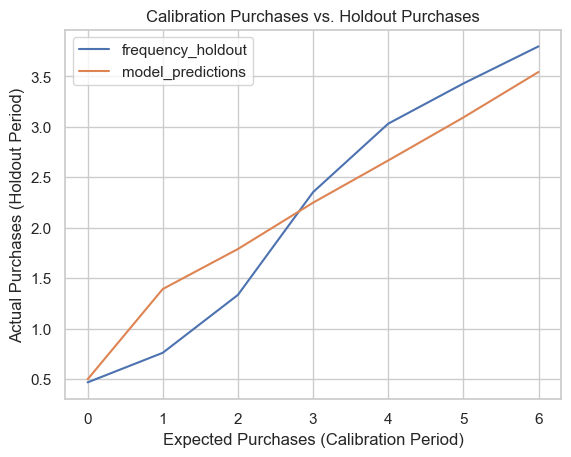

In [62]:
# Yellow Cab
############
fit_and_plot_bgf(yellow_cab_customers, '2018-01-02', '2018-12-31', penalizer_coef=10)

For Yellow Cab, the predictions align well only for individuals with exactly 3 repeat transactions, while there is some divergence for others.

### 3.4. Hypothesis 4: Number of transactions per season

- H0: The transaction counts of the companies do not vary with the seasons and remain the same in every season.
- H1: The transaction counts of the companies vary with the seasons, and they are not the same in every season.

In [63]:
# Calculating the count of transactions for every 3-month period
################################################################
df['Date of Travel'] = pd.to_datetime(df['Date of Travel'])
df['YearMonth'] = df['Date of Travel'].dt.strftime('%Y-%m')
df['Quarter'] = df['Date of Travel'].dt.to_period('Q').astype(str)

quarterly_transaction_count = df.groupby(['Company', 'Quarter'])['Transaction ID'].count().reset_index()

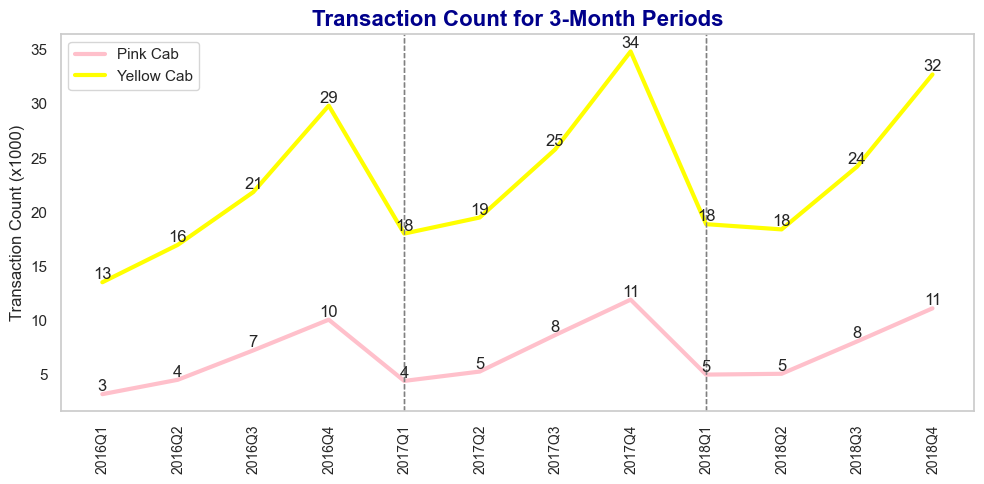

In [64]:
# Transaction count for 3-month periods
#######################################
plt.figure(figsize=(10, 5))
colors = ['pink', 'yellow']
quarters = quarterly_transaction_count['Quarter'].unique()

for i, (company, data) in enumerate(quarterly_transaction_count.groupby('Company')):
    plt.plot(data['Quarter'], data['Transaction ID'], label=company, color=colors[i], linewidth=3.0)
    plt.title('Transaction Count for 3-Month Periods', fontsize=16, fontweight='bold', color='darkblue')
    plt.xticks(rotation=45)
    plt.grid(False)

    quarterly_means = []
    for quarter in quarters:
        mean = np.mean(data[data['Quarter'] == quarter]['Transaction ID'])
        quarterly_means.append(mean)

    for j, mean in enumerate(quarterly_means):
        mean_display = f'{int(mean) // 1000:.0f}'
        plt.text(quarters[j], mean, mean_display, ha='center', va='bottom',fontsize=12)

    for k in range(1, len(quarters)):
        if k % 4 == 0:
            plt.axvline(quarters[k], color='gray', linestyle='--', linewidth=1)

plt.legend(loc='upper left')
plt.ylabel('Transaction Count (x1000)')

plt.gca().get_xaxis().set_tick_params(rotation=90, labelsize=10)
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x // 1000):.0f}'))

plt.tight_layout()
plt.show()

- When examining the graph, it can be observed that there is an increasing trend in customer travel demand from the 1st quarter to the 4th quarter. 

- This trend can be attributed to the beginning of the holiday season in the United States during the fall, along with increased shopping demand due to discount days.

- In order to statistically assess the stationarity, trend, and seasonality of the data, the Augmented Dickey-Fuller (ADF) test and Seasonal-Trend decomposition using Loess (STL) decomposition have been performed, respectively.

In [65]:
# ADF test - Stationarity
#########################
seasonal_period = 4

for i, company in enumerate(quarterly_transaction_count['Company'].unique()):
    company_data = quarterly_transaction_count[quarterly_transaction_count['Company'] == company]['Transaction ID']
    
    adf_result = adfuller(company_data)
    
    print(f'ADF Test Result for {company}:')
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values: {str(adf_result[4])}')
    if adf_result[1] <= 0.05:
        print('Time Series is Stationary (H0 Rejected)')
    else:
        print('Time Series is Non-Stationary (H0 Accepted)')
    
    print('-' * 40)

ADF Test Result for Pink Cab:
ADF Statistic: -0.4746
p-value: 0.8969
Critical Values: {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.8438679591836733}
Time Series is Non-Stationary (H0 Accepted)
----------------------------------------
ADF Test Result for Yellow Cab:
ADF Statistic: 0.3029
p-value: 0.9775
Critical Values: {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.8438679591836733}
Time Series is Non-Stationary (H0 Accepted)
----------------------------------------


It has been observed that the data for both companies' transaction counts are not stationary.

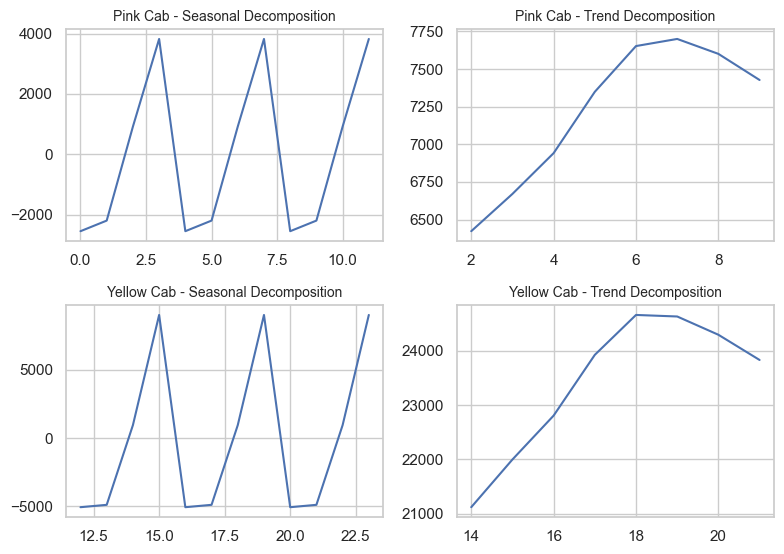

In [66]:
# STL decomposition - Trend and Seasonality
###########################################
unique_companies = quarterly_transaction_count['Company'].unique()

fig, axes = plt.subplots(nrows=len(unique_companies), ncols=2, figsize=(8, 3 * len(unique_companies)))

for i, company in enumerate(unique_companies):
    company_data = quarterly_transaction_count[quarterly_transaction_count['Company'] == company]['Transaction ID']
    
    decomposition = sm.tsa.seasonal_decompose(company_data, period=seasonal_period)
    
    axes[i, 0].set_title(f'{company} - Seasonal Decomposition',fontsize=10 )
    axes[i, 0].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=1.5)  # Kalınlık ayarı
    
    axes[i, 1].set_title(f'{company} - Trend Decomposition', fontsize=10)
    axes[i, 1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=1.5)  # Kalınlık ayarı

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

- The seasonality is quite evident for both companies in this analysis. 
- Furthermore, while the trend initially exhibits growth, it shows a decline towards the end. This may imply that, in conjunction with seasonal effects, the overall trend is decelerating or diminishing.

The presence of any seasonality in the cities has also been examined below.

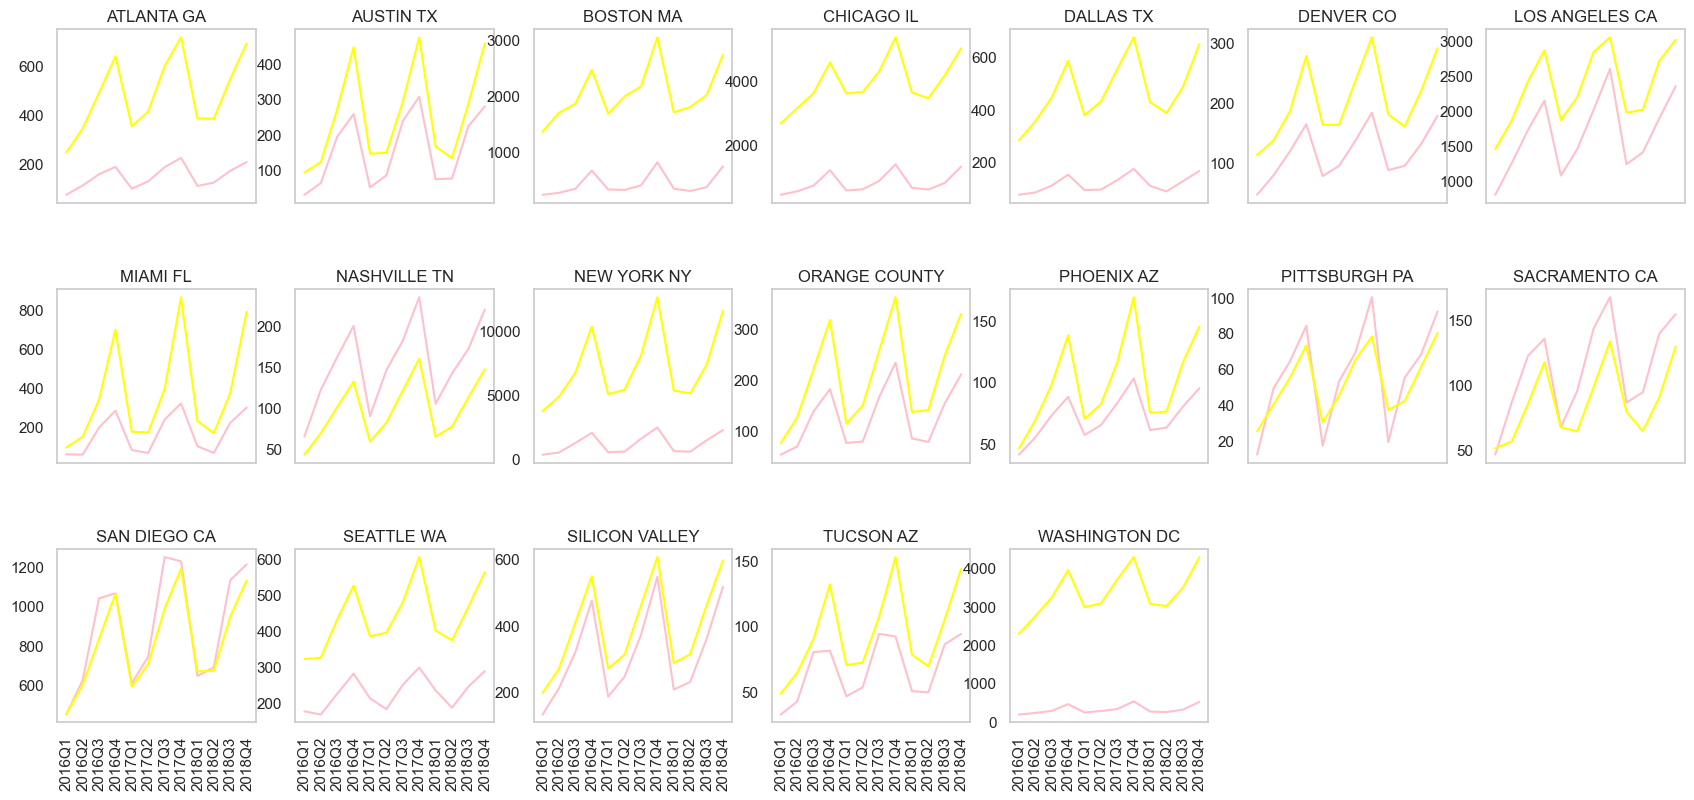

In [67]:
# Transaction count for 3-month periods for each city
#####################################################
quarterly_transaction_count_city = df.groupby(['Company', 'Quarter', 'City'])['Transaction ID'].count().reset_index()

cities = quarterly_transaction_count_city['City'].unique()

fig, axes = plt.subplots(3, 7, figsize=(21, 9), sharex=True)
fig.subplots_adjust(hspace=0.5)

for ax in axes[-1, :]:
    ax.xaxis.set_tick_params(rotation=90)

for i, city in enumerate(cities):
    row = i // 7
    col = i % 7
    
    city_data = quarterly_transaction_count_city[quarterly_transaction_count_city['City'] == city]
   
    axes[row, col].grid(False)
    
    sns.lineplot(x='Quarter', y='Transaction ID', hue='Company', data=city_data, 
                 ax=axes[row, col], legend=False, palette=['pink', 'yellow'])
    
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')
    axes[row, col].set_title(f'{city}')
    
for i in range(len(cities), 3*7):
    row = i // 7
    col = i % 7
    fig.delaxes(axes[row, col])

plt.show()

- When cities are examined individually, almost similar seasonality pattern is observed for all cities.

### 3.5. Hypothesis 5: Customer acquisition rate

- H0: Yellow Cab and Pink Cab have similar customer acquisition rates in specific demographic segments.
- H1: Yellow Cab and Pink Cab have different customer acquisition rates in specific demographic segments.

#### Pink Cab - Demografic Segments

In [68]:
# Pink Cab customers - Age_Group
################################
age_bins = [18, 28, 38, 65]
age_labels = ['Young Adults (18-28)', 'Middle-aged Adults (29-38)', 'Adults (39-65)']

pink_cab_customers['Age_Group'] = pd.qcut(pink_cab_customers['Age'], q=3, labels=age_labels)

unique_age_groups = pink_cab_customers['Age_Group'].unique()

for group in unique_age_groups:
    number_of_customers_age = pink_cab_customers[pink_cab_customers["Age_Group"] == group].shape[0]
    print(f'{group}, Number of Customers: {number_of_customers_age}')
    print('-' * 40)

Young Adults (18-28), Number of Customers: 30295
----------------------------------------
Adults (39-65), Number of Customers: 28121
----------------------------------------
Middle-aged Adults (29-38), Number of Customers: 26295
----------------------------------------


In [69]:
# Pivot table - Pink Cab
########################
users_per_city_pink = pink_cab_customers.groupby('City')['Users'].first()

pivot_table_pink = pink_cab_customers.pivot_table(
    values=['Customer ID', 'Profit'],
    index=[ 'Gender', 'Age_Group', 'City'],
    aggfunc={'Customer ID': 'count', 'Profit': 'sum'}
)

pivot_table_pink.columns = ['Customer_Count', 'Total_Profit']

pivot_table_pink['Total_Profit_per_Customer'] = pivot_table_pink['Total_Profit'] / pivot_table_pink['Customer_Count']
pivot_table_pink['Customer_to_User_Ratio'] = (pivot_table_pink['Customer_Count'] / users_per_city_pink[pivot_table_pink.index.get_level_values('City')].values)*100

sorted_pivot_table_pink = pivot_table_pink.sort_values(by='Customer_to_User_Ratio', ascending=False)

# Top 10 in terms of customer count to user ratio - Pink Cab
############################################################
sorted_pivot_table_pink.head(10)

Customer_Count  Total_Profit  Total_Profit_per_Customer  Customer_to_User_Ratio
Gender Age_Group                  City                                                                                          
Male   Young Adults (18-28)       NASHVILLE TN              376     14781.264                     39.312                   4.056
Female Young Adults (18-28)       NASHVILLE TN              329     10604.626                     32.233                   3.549
Male   Young Adults (18-28)       SACRAMENTO CA             244      9703.469                     39.768                   3.464
Female Young Adults (18-28)       PITTSBURGH PA             126      3130.078                     24.842                   3.459
Male   Middle-aged Adults (29-38) NASHVILLE TN              311     10004.020                     32.167                   3.355
Female Adults (39-65)             PITTSBURGH PA             121      3274.648                     27.063                   3.321
       Middle-aged Adults (29-38) SACRAMENTO CA             233      7357.830                     31.579                   3.308
       Adults (39-65)             SACRAMENTO CA             233      9444.854                     40.536                   3.308
       Middle-aged Adults (29-38) PITTSBURGH PA             120      3111.121                     25.926                   3.294
                                  NASHVILLE TN              294     10804.655                     36.751                   3.172

In [70]:
# Total customer-to-user ratio values for cities - Pink Cab
###########################################################
# It indicates the percentage of taxi users in that city who prefer Pink Cab.

city_customer_to_user_ratio_pink = pivot_table_pink.groupby('City')['Customer_to_User_Ratio'].sum()

city_customer_to_user_ratio_pink_sorted = city_customer_to_user_ratio_pink.sort_values(ascending=False)

city_customer_to_user_ratio_pink_sorted.head(5)

City
NASHVILLE TN    19.860
SACRAMENTO CA   18.938
PITTSBURGH PA   18.721
SAN DIEGO CA    15.247
PHOENIX AZ      14.088
Name: Customer_to_User_Ratio, dtype: float64

In [71]:
df_city.tail(5)

,City,Population,Users
15,SACRAMENTO CA,545776.000,7044.000
16,PITTSBURGH PA,542085.000,3643.000
17,WASHINGTON DC,418859.000,127001.000
18,NASHVILLE TN,327225.000,9270.000
19,BOSTON MA,248968.000,80021.000


- Considering the total number of users in cities, it is observed that Pink Cab has the highest customer ratio among the young adults group living in Nashville.
- In the top 10 demographic groups, it is observed that 7 of them belong to the female group.
- Prominent cities among the top 5 include Nashville, Pittsburgh, and Sacramento. However, a noteworthy point from previous analyses is that Pink Cab operates at a loss of over 13% in these three cities. 
- Furthermore, these cities have among the lowest populations among the examined cities. This could be one of the reasons for the lower profit per customer. 
- Therefore, it is evident that Pink Cab requires operational improvements in these cities.

In [72]:
# Bottom 10 in terms of customer count to user ratio - Pink Cab
###############################################################
sorted_pivot_table_pink.head(10)

Customer_Count  Total_Profit  Total_Profit_per_Customer  Customer_to_User_Ratio
Gender Age_Group                  City                                                                                          
Male   Young Adults (18-28)       NASHVILLE TN              376     14781.264                     39.312                   4.056
Female Young Adults (18-28)       NASHVILLE TN              329     10604.626                     32.233                   3.549
Male   Young Adults (18-28)       SACRAMENTO CA             244      9703.469                     39.768                   3.464
Female Young Adults (18-28)       PITTSBURGH PA             126      3130.078                     24.842                   3.459
Male   Middle-aged Adults (29-38) NASHVILLE TN              311     10004.020                     32.167                   3.355
Female Adults (39-65)             PITTSBURGH PA             121      3274.648                     27.063                   3.321
       Middle-aged Adults (29-38) SACRAMENTO CA             233      7357.830                     31.579                   3.308
       Adults (39-65)             SACRAMENTO CA             233      9444.854                     40.536                   3.308
       Middle-aged Adults (29-38) PITTSBURGH PA             120      3111.121                     25.926                   3.294
                                  NASHVILLE TN              294     10804.655                     36.751                   3.172

In [73]:
city_customer_to_user_ratio_pink_sorted.tail(5)

City
BOSTON MA       6.481
DALLAS TX       6.228
CHICAGO IL      5.692
NEW YORK NY     4.623
WASHINGTON DC   2.907
Name: Customer_to_User_Ratio, dtype: float64

In [74]:
df_city.head(5)

,City,Population,Users
0,NEW YORK NY,8405837.000,302149.000
1,CHICAGO IL,1955130.000,164468.000
2,LOS ANGELES CA,1595037.000,144132.000
3,MIAMI FL,1339155.000,17675.000
4,SILICON VALLEY,1177609.000,27247.000


- The city where Pink Cab is the least effective in terms of customer ratio is Washington DC for all gender and age groups. 
- Additionally, it is observed that the company has a significantly low customer ratio for women of all age groups residing in New York. 
- In a city like New York where the average profit per customer is high, these low ratios could be another factor affecting Pink Cab's profitability.

#### Yellow Cab - Demografic Segments

In [75]:
# Yellow Cab customers - Age_Group
###################################
age_bins = [18, 28, 38, 65]
age_labels = ['Young Adults (18-28)', 'Middle-aged Adults (29-38)', 'Adults (39-65)']

yellow_cab_customers['Age_Group'] = pd.qcut(yellow_cab_customers['Age'], q=3, labels=age_labels)

unique_age_groups_yellow = yellow_cab_customers['Age_Group'].unique()

for group in unique_age_groups_yellow:
    number_of_customers_age_yellow = yellow_cab_customers[yellow_cab_customers["Age_Group"] == group].shape[0]
    print(f'{group}, Number of Customers: {number_of_customers_age_yellow}')
    print('-' * 40)

Young Adults (18-28), Number of Customers: 97897
----------------------------------------
Middle-aged Adults (29-38), Number of Customers: 85317
----------------------------------------
Adults (39-65), Number of Customers: 91467
----------------------------------------


In [77]:
# Pivot table - Yellow Cab
##########################
users_per_city_yellow = yellow_cab_customers.groupby('City')['Users'].first()

pivot_table_yellow = yellow_cab_customers.pivot_table(
    values=['Customer ID', 'Profit', 'Price Charged'],
    index=['Gender', 'Age_Group', 'City'],
    aggfunc={'Customer ID': 'count', 'Profit': 'sum'}
)

pivot_table_yellow.columns = ['Customer_Count', 'Total_Profit']

pivot_table_yellow['Total_Profit_per_Customer'] = pivot_table_yellow['Total_Profit'] / pivot_table_yellow['Customer_Count']
pivot_table_yellow['Customer_to_User_Ratio'] = (pivot_table_yellow['Customer_Count'] / users_per_city_yellow[pivot_table_yellow.index.get_level_values('City')].values)*100

sorted_pivot_table_yellow = pivot_table_yellow.sort_values(by='Customer_to_User_Ratio', ascending=False)

# Top 10 in terms of customer count to user ratio - Yellow Cab
##############################################################
sorted_pivot_table_yellow.head(10)

Customer_Count  Total_Profit  Total_Profit_per_Customer  Customer_to_User_Ratio
Gender Age_Group                  City                                                                                          
Male   Young Adults (18-28)       WASHINGTON DC            8281    684396.708                     82.647                   6.520
                                  NEW YORK NY             18920   5818055.202                    307.508                   6.262
       Adults (39-65)             CHICAGO IL              10190    668369.912                     65.591                   6.196
       Young Adults (18-28)       CHICAGO IL               9866    652848.378                     66.172                   5.999
                                  BOSTON MA                4776    289773.861                     60.673                   5.968
       Adults (39-65)             WASHINGTON DC            7438    611049.950                     82.152                   5.857
       Middle-aged Adults (29-38) WASHINGTON DC            7187    588398.968                     81.870                   5.659
       Adults (39-65)             BOSTON MA                4515    275303.051                     60.975                   5.642
                                  NEW YORK NY             17048   5294988.203                    310.593                   5.642
       Middle-aged Adults (29-38) BOSTON MA                4408    271889.968                     61.681                   5.509

In [78]:
# Total customer-to-user ratio values for cities - Yellow Cab
###########################################################
# It indicates the percentage of taxi users in that city who prefer Yellow Cab.

city_customer_to_user_ratio_yellow = pivot_table_yellow.groupby('City')['Customer_to_User_Ratio'].sum()

city_customer_to_user_ratio_yellow_sorted = city_customer_to_user_ratio_yellow.sort_values(ascending=False)

city_customer_to_user_ratio_yellow_sorted.head(5)

City
WASHINGTON DC   31.531
BOSTON MA       30.624
CHICAGO IL      28.738
NEW YORK NY     28.436
DALLAS TX       25.441
Name: Customer_to_User_Ratio, dtype: float64

In [79]:
df_city.head(5)

,City,Population,Users
0,NEW YORK NY,8405837.000,302149.000
1,CHICAGO IL,1955130.000,164468.000
2,LOS ANGELES CA,1595037.000,144132.000
3,MIAMI FL,1339155.000,17675.000
4,SILICON VALLEY,1177609.000,27247.000


- All of the top 10 demographic groups with the highest Yellow Cab user ratios consist entirely of male individuals.
- The groups with the highest customer ratios are young adults living in cities like New York, NY and Washington DC.
- In addition to these, other significant cities within the top 10 include Chicago, IL, and Boston, MA.
- The fact that Yellow Cab has a high customer ratio and does not incur any losses in a city like New York, where profitability per customer is high, is a sign of the company's effective pricing strategy.

In [80]:
# Bottom 10 in terms of customer count - Yellow Cab
###################################################
sorted_pivot_table_yellow.tail(10)

Customer_Count  Total_Profit  Total_Profit_per_Customer  Customer_to_User_Ratio
Gender Age_Group                  City                                                                                          
Female Middle-aged Adults (29-38) SACRAMENTO CA             167     11443.504                     68.524                   2.371
Male   Adults (39-65)             SAN DIEGO CA             1635    155525.046                     95.122                   2.336
Female Young Adults (18-28)       NASHVILLE TN              212     14358.248                     67.728                   2.287
       Adults (39-65)             SAN DIEGO CA             1524    146439.783                     96.089                   2.177
Male   Middle-aged Adults (29-38) NASHVILLE TN              193     15151.471                     78.505                   2.082
Female Middle-aged Adults (29-38) NASHVILLE TN              192     13148.906                     68.484                   2.071
Male   Middle-aged Adults (29-38) SACRAMENTO CA             142      7797.380                     54.911                   2.016
Female Middle-aged Adults (29-38) SAN DIEGO CA             1371    130852.756                     95.443                   1.959
Male   Adults (39-65)             NASHVILLE TN              172     14078.935                     81.854                   1.855
Female Adults (39-65)             NASHVILLE TN              165     11221.323                     68.008                   1.780

In [81]:
city_customer_to_user_ratio_yellow_sorted.tail(5)

City
SILICON VALLEY   17.330
PITTSBURGH PA    17.321
SACRAMENTO CA    14.665
SAN DIEGO CA     14.024
NASHVILLE TN     12.611
Name: Customer_to_User_Ratio, dtype: float64

- It is evident that the cities with the lowest customer ratios for Yellow Cab are Sacramento, CA, San Diego CA, and Nashville TN. 
- These cities are the ones where Pink Cab is most effective in terms of customer ratios, and they also happen to have relatively lower populations.

In [82]:
# Compare total customer ratios of Pink Cab and Yellow Cab
##########################################################
city_comparison = pd.DataFrame({
    'Pink_Cab_Customer_to_User_Ratio': city_customer_to_user_ratio_pink_sorted,
    'Yellow_Cab_Customer_to_User_Ratio': city_customer_to_user_ratio_yellow_sorted
})


pink_higher_ratio_cities = city_comparison[city_comparison['Pink_Cab_Customer_to_User_Ratio'] > city_comparison['Yellow_Cab_Customer_to_User_Ratio']]
pink_higher_ratio_cities

,Pink_Cab_Customer_to_User_Ratio,Yellow_Cab_Customer_to_User_Ratio
City,,
NASHVILLE TN,19.860,12.611
PITTSBURGH PA,18.721,17.321
SACRAMENTO CA,18.938,14.665
SAN DIEGO CA,15.247,14.024


- Within the examined cities, it can be observed that Pink Cab has a higher total customer percentage than Yellow Cab in only four cities.

## Conclusion

- **Hypothesis 1:**
H1: There is a statistically significant difference in loyal customer count between Pink Cab and Yellow Cab.
    
- **Hypothesis 2:**
H1: There is a difference in loyal customer count between Pink Cab and Yellow Cab.

- **Hypothesis 3:**
H1: The expected transaction count for Yellow Cab and Pink Cab companies is different over a 12-month period.

- **Hypothesis 4:**
H1: The transaction counts of the companies vary with the seasons, and they are not the same in every season.

- **Hypothesis 5:**
H1: Yellow Cab and Pink Cab have different customer acquisition rates in specific demographic segments.